In [254]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import glob
import gzip
import tensorflow as tf
from tensorflow import keras
import time

import matplotlib.pyplot as plt

SEED = 1013
np.random.seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd 
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
import pickle
import emoji
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.util import ngrams

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [290]:
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english'))

In [255]:
import collections
#df=pd.read_csv('/Users/Meghna/Desktop/tweets_for_language_model_noRT.csv')
df = pd.read_csv('/Users/Meghna/Desktop/human_annotated_black_tweets.csv')
dff = pd.read_csv('/Users/Meghna/Desktop/human_annotated_black_tweets2.csv')
dfff = pd.read_csv('/Users/Meghna/Desktop/human_annotated_nonblack_tweets.csv')

In [256]:
#races = df['races'].to_list()
races = df['race'].to_list() + dff['race'].to_list() + dfff['race'].to_list()

# count = 0
# for val in races:
#     if val == 1:
#         count += 1
# print(count)
# df.head()

In [257]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #remove mentions
pat2 = r'https?://[^ ]+' #remove hyperlinks
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml') # remove html tags
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?") #remove byte order marks
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    lower_case = stripped.lower()
    lower_case = emoji.demojize(lower_case, language='en')
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled) #remove hashtag
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [258]:
#tweets = df['tweets'].to_list()
tweets = df['tweet'].to_list() + dff['tweet'].to_list() + dfff['tweet'].to_list()
cleaned_tweets = []
for tweet in tweets:
    cleaned_tweets.append(tweet_cleaner_updated(tweet))

In [259]:
num_of_words = []
for tweet in cleaned_tweets:
    length = 0
    for word in tweet.split():
        if word != '':
            length += 1
    num_of_words.append(length)
    

In [260]:
avg_word_length = []
for tweet in cleaned_tweets:
    if tweet != '':
        lengths = []
        for word in tweet.split():
            if word != " ":
                lengths.append(len(word))
        avg_word_length.append(sum(lengths)/len(lengths))
    else:
        avg_word_length.append(0)

In [261]:
new_df = pd.DataFrame()
new_df['races'] = races
new_df['tweets'] = cleaned_tweets
new_df['num_of_words'] = num_of_words
new_df['avg_word_length'] = avg_word_length

In [262]:
new_df

,races,tweets,num_of_words,avg_word_length
0,1,most of us have not been inside covid icu and ...,35,3.942857
1,1,not the masks most people are wearing,7,4.428571
2,1,black peoples reluctance to go first with the ...,32,5.218750
3,1,when the biden administration takes office we ...,42,4.428571
4,1,best cybermonday deals for working from home a...,8,6.125000
...,...,...,...,...
6817,0,dang just learned something new and useful tha...,14,4.785714
6818,0,will you all be selling any of the christmas s...,29,4.689655
6819,0,shop small during the pandemic via,6,4.833333
6820,0,me look this company sent me free face masks p...,39,4.179487


In [263]:
negative_tweets = new_df[new_df['races'] == 0]
positive_tweets = new_df[new_df['races'] == 1]

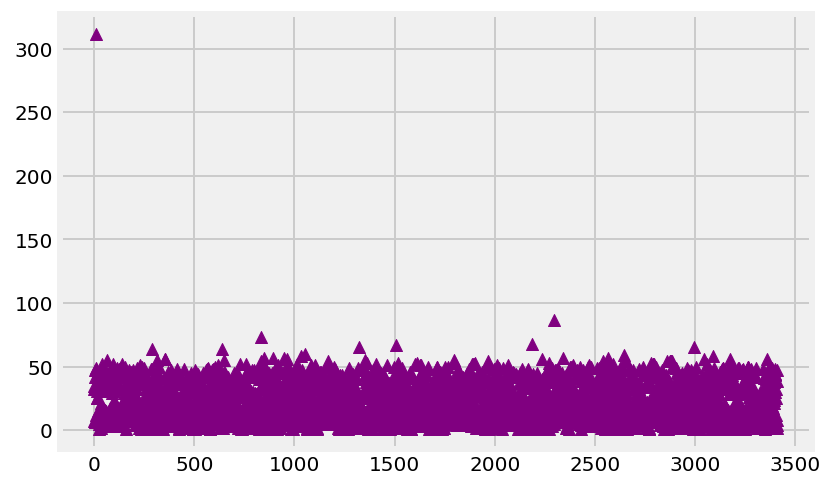

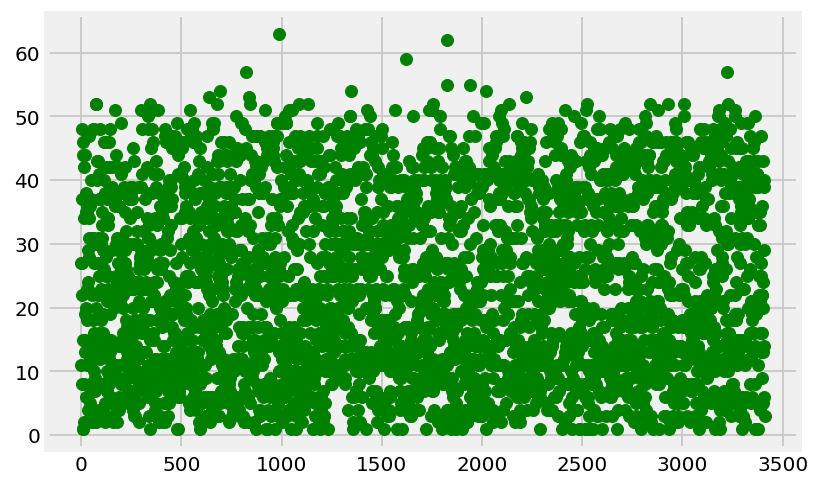

In [265]:
neg_tweets_num_of_words = negative_tweets['num_of_words'].to_list()
pos_tweets_num_of_words = positive_tweets['num_of_words'].to_list()
len(neg_tweets_num_of_words)
# x_pos = [i for i in range(18602)]
# x_neg = [i for i in range(18602)]
x_pos = [i for i in range(3411)]
x_neg = [i for i in range(3411)]
plt.scatter(x_pos, pos_tweets_num_of_words,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(x_neg, neg_tweets_num_of_words, marker='o',  color = 'green')
plt.show()

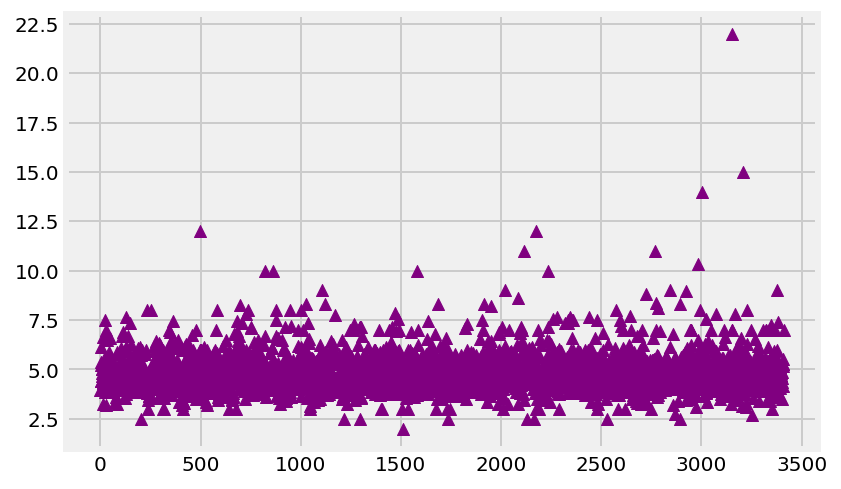

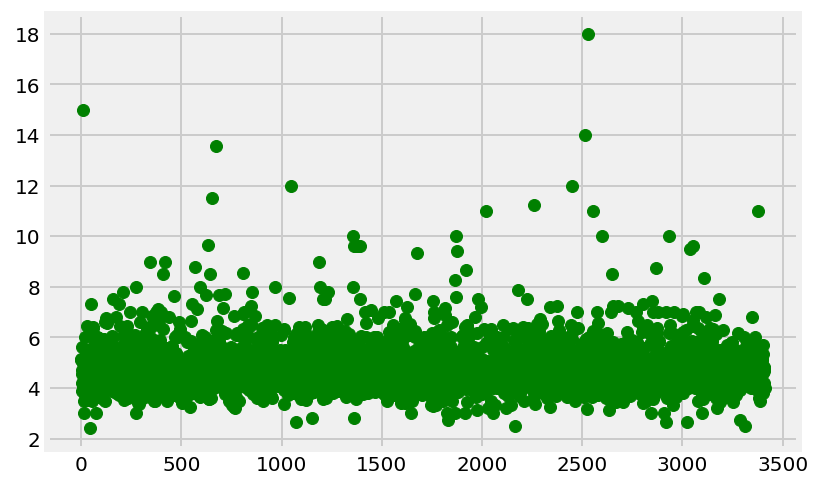

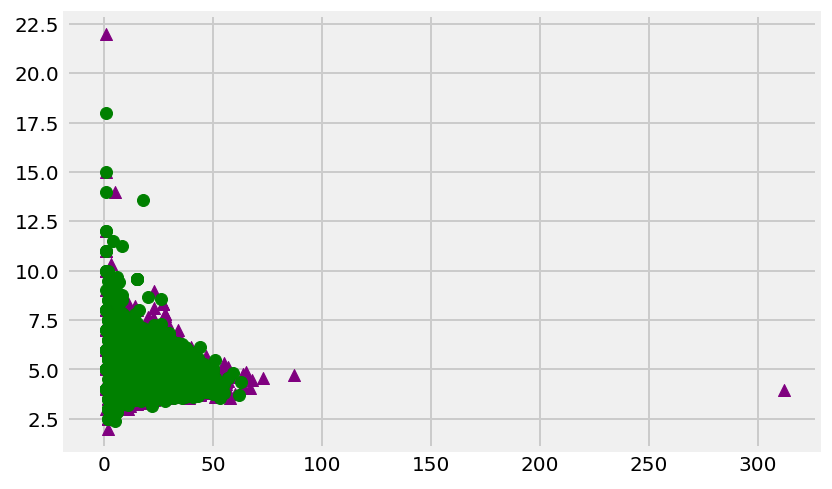

In [283]:
neg_tweets_avg_word_len = negative_tweets['avg_word_length'].to_list()
pos_tweets_avg_word_len = positive_tweets['avg_word_length'].to_list()
len(neg_tweets_num_of_words)
# x_pos = [i for i in range(18602)]
# x_neg = [i for i in range(18602)]
x_pos = [i for i in range(3411)]
x_neg = [i for i in range(3411)]
plt.scatter(x_pos, pos_tweets_avg_word_len,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(x_neg, neg_tweets_avg_word_len, marker='o', color = 'green')
plt.show()

plt.scatter(pos_tweets_num_of_words, pos_tweets_avg_word_len,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
#plt.show()
plt.scatter(neg_tweets_num_of_words, neg_tweets_avg_word_len, marker='o', color = 'green')
plt.show()

In [268]:
df_num_words = pd.DataFrame()
negs = negative_tweets['num_of_words'].to_list()
pos = positive_tweets['num_of_words'].to_list()
df_num_words['neg_num_of_words'] = negs
df_num_words['pos_num_of_words'] = pos
df_num_words

,neg_num_of_words,pos_num_of_words
0,27,35
1,11,7
2,37,32
3,48,42
4,22,8
...,...,...
3406,14,47
3407,29,8
3408,6,4
3409,39,39


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

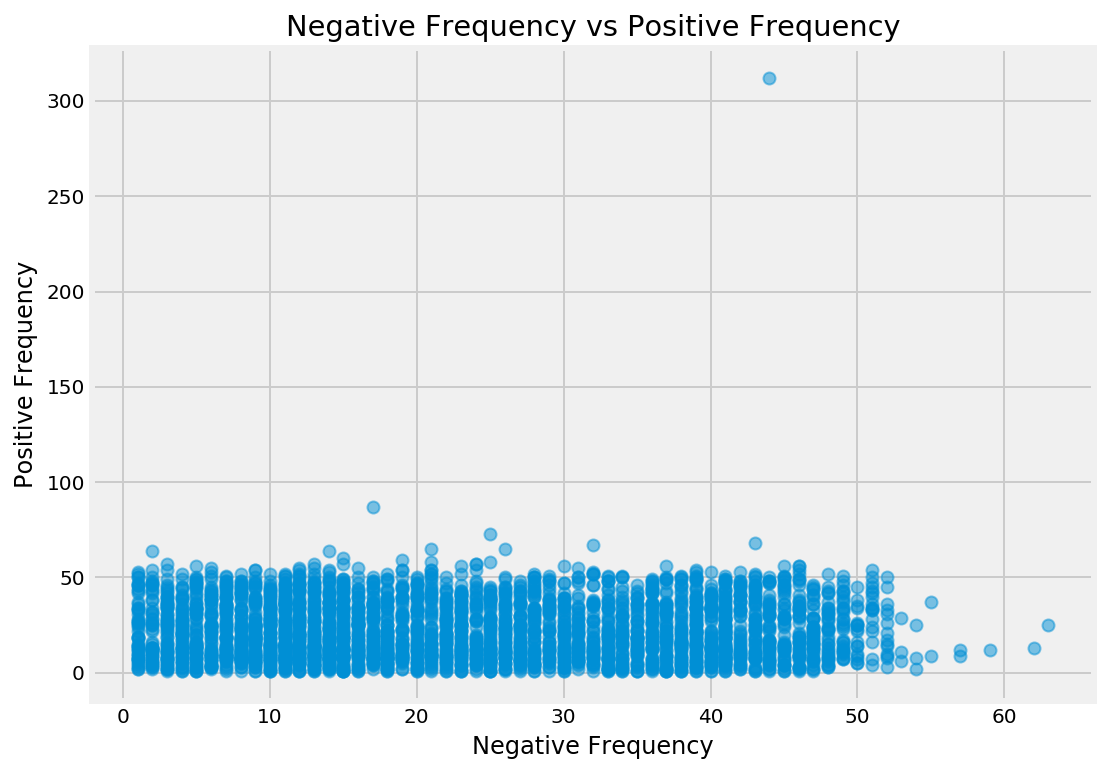

In [269]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_num_of_words", y="pos_num_of_words",fit_reg=False, scatter_kws={'alpha':0.5}, data=df_num_words)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [270]:
df_avg_wordlen = pd.DataFrame()
negs = negative_tweets['avg_word_length'].to_list()
pos = positive_tweets['avg_word_length'].to_list()
df_avg_wordlen['neg_avg_word_length'] = negs
df_avg_wordlen['pos_avg_word_length'] = pos
df_avg_wordlen

,neg_avg_word_length,pos_avg_word_length
0,5.148148,3.942857
1,5.090909,4.428571
2,4.729730,5.218750
3,4.208333,4.428571
4,4.545455,6.125000
...,...,...
3406,4.785714,4.170213
3407,4.689655,5.250000
3408,4.833333,5.500000
3409,4.179487,5.179487


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

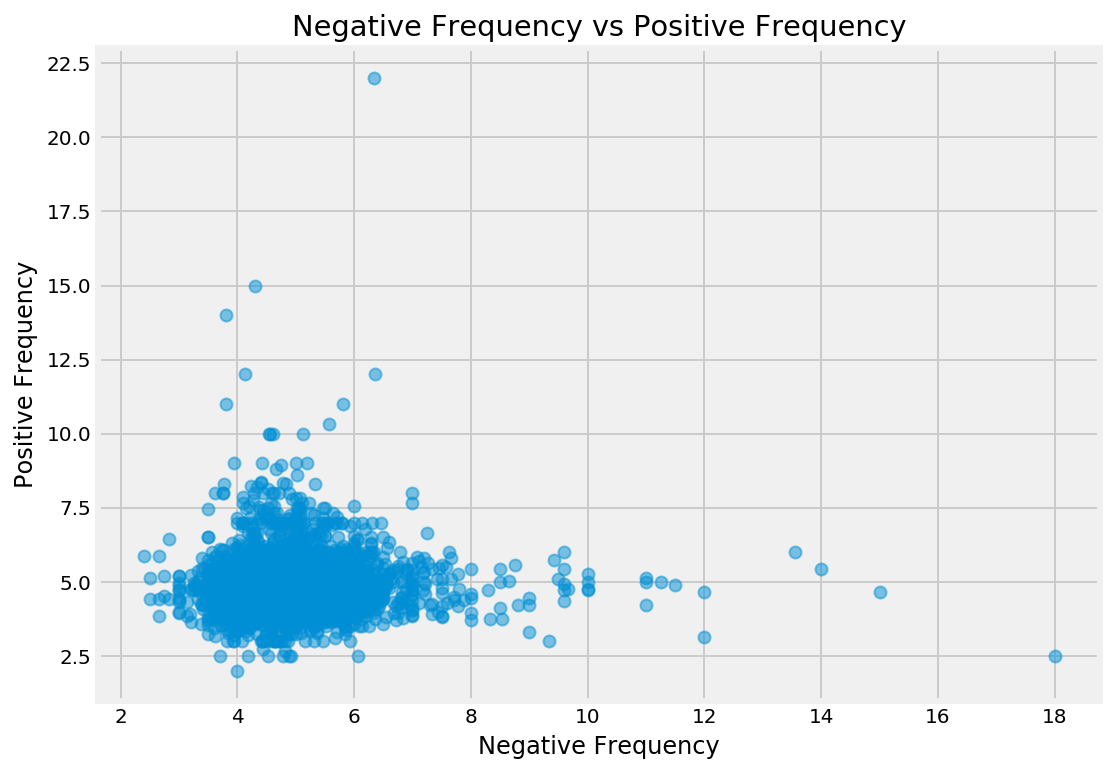

In [271]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_avg_word_length", y="pos_avg_word_length",fit_reg=False, scatter_kws={'alpha':0.5}, data=df_avg_wordlen)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [272]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+' #remove mentions
pat2 = r'https?://[^ ]+' #remove hyperlinks
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
#negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
#                 "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
#                 "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
#                 "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
#                 "mustn't":"must not"}
#neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated2(text):
    soup = BeautifulSoup(text, 'lxml') # remove html tags
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?") #remove byte order marks
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    #lower_case = stripped.lower()
    #lower_case = emoji.demojize(lower_case, language='en')
    #neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    #letters_only = re.sub("[^a-zA-Z]", " ", stripped) #remove hashtag
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
#     words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
#     return (" ".join(words)).strip()

    return stripped

In [273]:
uncleaned_tweets = []
for tweet in tweets:
    uncleaned_tweets.append(tweet_cleaner_updated2(tweet))

In [274]:
cleaned_tweets[3]

'when the biden administration takes office we will continue to battle the economic impact of the pandemic we have to make sure that no one is left behind by our recovery and we need to provide as much assistance as possible now'

In [275]:
uncleaned_tweets[3]
print(re.split(" |\n",uncleaned_tweets[3])[0] == '')

False


In [276]:
from advertools.emoji import extract_emoji

In [517]:
uncleaned_num_of_words = []
for tweet in uncleaned_tweets:
    length = 0
    for word in re.split(" |\n",tweet):
        if word != '':
            length += 1
    uncleaned_num_of_words.append(length)
    
uncleaned_avg_word_length = []
for tweet in uncleaned_tweets:
    if tweet != '':
        lengths = []
        for word in re.split(" |\n",tweet):
            if word != " ":
                lengths.append(len(word))
        uncleaned_avg_word_length.append(sum(lengths)/len(lengths))
    else:
        uncleaned_avg_word_length.append(0)
        
        
uncleaned_count_emoji = []
for tweet in uncleaned_tweets:
    count = 0
    for i in range(len(extract_emoji(tweet)['emoji_flat_text'])):
        count += 1
    uncleaned_count_emoji.append(count)
        



In [518]:
count_punctuation = lambda l1,l2: sum([1 for x in l1 if x in l2])
uncleaned_count_puncts = []
for tweet in uncleaned_tweets:
    uncleaned_count_puncts.append(count_punctuation(tweet,set(string.punctuation)))

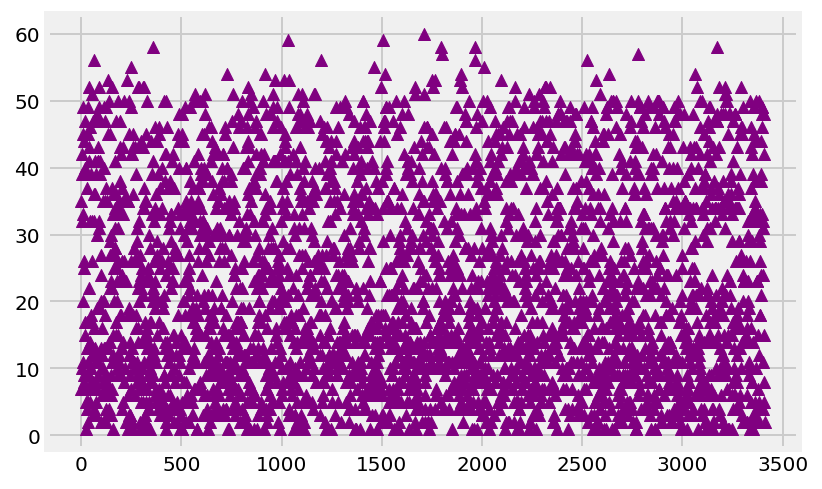

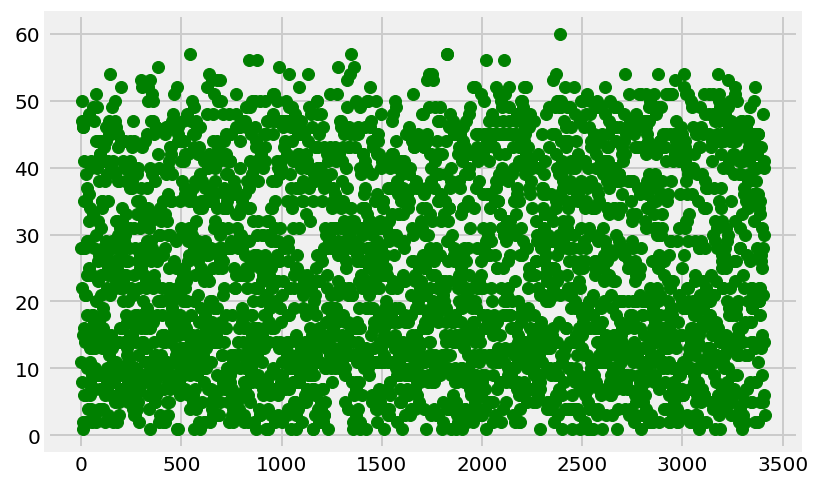

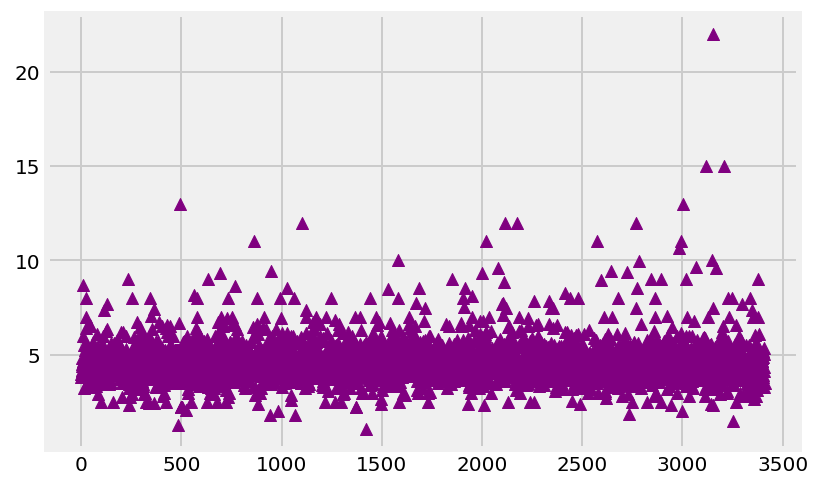

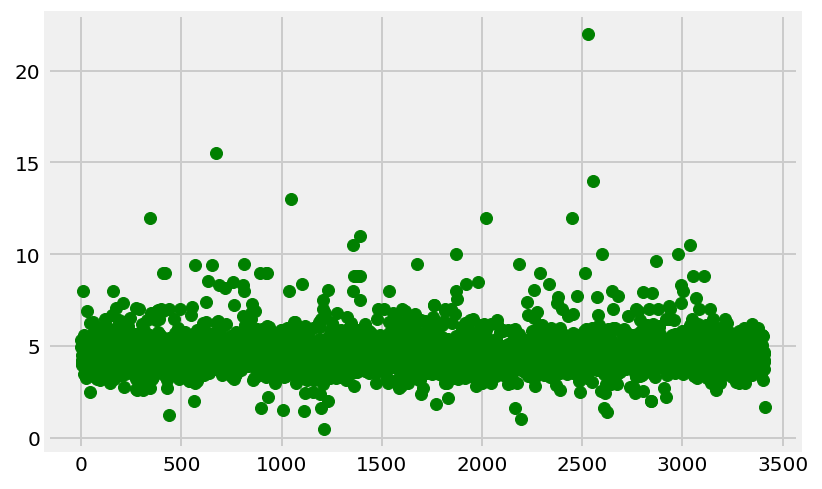

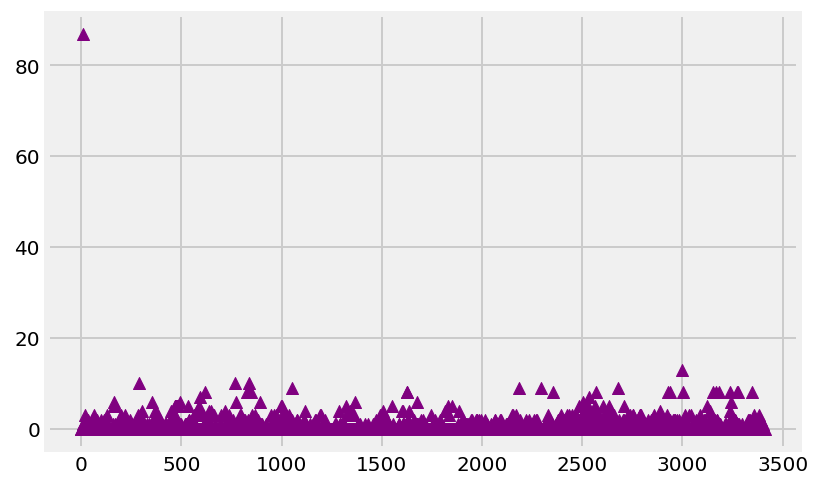

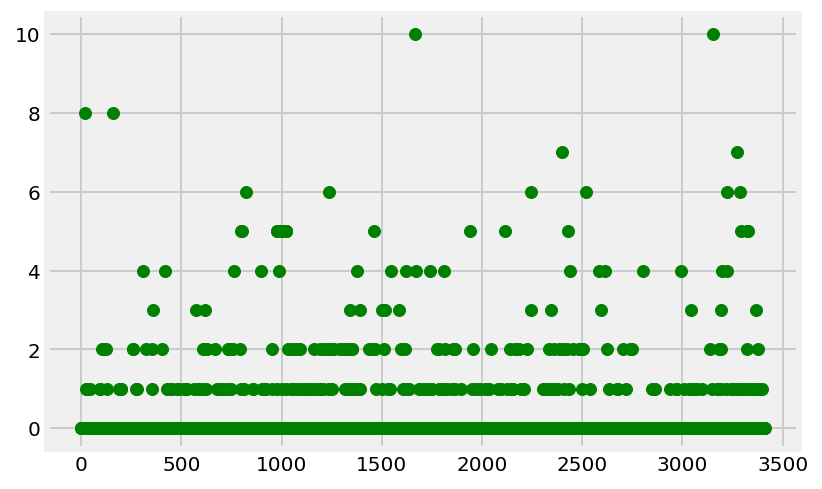

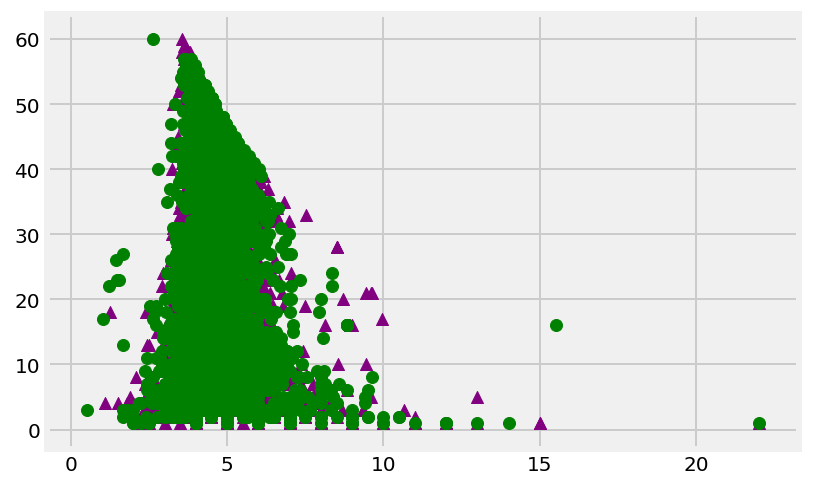

In [285]:
uncleaned_new_df = pd.DataFrame()
uncleaned_new_df['races'] = races
uncleaned_new_df['tweets'] = uncleaned_tweets
uncleaned_new_df['num_of_words'] = uncleaned_num_of_words
uncleaned_new_df['avg_word_length'] = uncleaned_avg_word_length
uncleaned_new_df['count_emoji'] = uncleaned_count_emoji
uncleaned_new_df['count_puncts'] = uncleaned_count_puncts

uncleaned_negative_tweets = uncleaned_new_df[uncleaned_new_df['races'] == 0]
uncleaned_positive_tweets = uncleaned_new_df[uncleaned_new_df['races'] == 1]

uncleaned_neg_tweets_num_of_words = uncleaned_negative_tweets['num_of_words'].to_list()
uncleaned_pos_tweets_num_of_words = uncleaned_positive_tweets['num_of_words'].to_list()
len(uncleaned_neg_tweets_num_of_words)
# uncleaned_x_pos = [i for i in range(18602)]
# uncleaned_x_neg = [i for i in range(18602)]
uncleaned_x_pos = [i for i in range(3411)]
uncleaned_x_neg = [i for i in range(3411)]
plt.scatter(uncleaned_x_pos, uncleaned_pos_tweets_num_of_words,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_neg_tweets_num_of_words, marker='o',  color = 'green')
plt.show()

uncleaned_neg_tweets_avg_word_len = uncleaned_negative_tweets['avg_word_length'].to_list()
uncleaned_pos_tweets_avg_word_len = uncleaned_positive_tweets['avg_word_length'].to_list()
len(uncleaned_neg_tweets_num_of_words)
# uncleaned_x_pos = [i for i in range(18602)]
# uncleaned_x_neg = [i for i in range(18602)]
uncleaned_x_pos = [i for i in range(3411)]
uncleaned_x_neg = [i for i in range(3411)]
plt.scatter(uncleaned_x_pos, uncleaned_pos_tweets_avg_word_len,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_neg_tweets_avg_word_len, marker='o', color = 'green')
plt.show()

uncleaned_df_emoji= pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['count_emoji'].to_list()
uncleaned_pos = uncleaned_positive_tweets['count_emoji'].to_list()
uncleaned_df_emoji['neg_count_emoji'] = uncleaned_negs
uncleaned_df_emoji['pos_count_emoji'] = uncleaned_pos
uncleaned_df_emoji


# uncleaned_x_pos = [i for i in range(18602)]
# uncleaned_x_neg = [i for i in range(18602)]
uncleaned_x_pos = [i for i in range(3411)]
uncleaned_x_neg = [i for i in range(3411)]
plt.scatter(uncleaned_x_pos, uncleaned_pos,marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_negs, marker='o', color = 'green')
plt.show()


uncleaned_df_num_words = pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['num_of_words'].to_list()
uncleaned_pos = uncleaned_positive_tweets['num_of_words'].to_list()
uncleaned_df_num_words['neg_num_of_words'] = uncleaned_negs
uncleaned_df_num_words['pos_num_of_words'] = uncleaned_pos
uncleaned_df_num_words


# import seaborn as sns
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x="neg_num_of_words", y="pos_num_of_words",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_num_words)
# plt.ylabel('Positive Frequency')
# plt.xlabel('Negative Frequency')
# plt.title('Negative Frequency vs Positive Frequency')


uncleaned_df_avg_wordlen = pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['avg_word_length'].to_list()
uncleaned_pos = uncleaned_positive_tweets['avg_word_length'].to_list()
uncleaned_df_avg_wordlen['neg_avg_word_length'] = uncleaned_negs
uncleaned_df_avg_wordlen['pos_avg_word_length'] = uncleaned_pos
uncleaned_df_avg_wordlen

# import seaborn as sns
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x="neg_avg_word_length", y="pos_avg_word_length",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_avg_wordlen)
# plt.ylabel('Positive Frequency')
# plt.xlabel('Negative Frequency')
# plt.title('Negative Frequency vs Positive Frequency')

# import seaborn as sns
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x="neg_count_emoji", y="pos_count_emoji",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_emoji)
# plt.ylabel('Positive Frequency')
# plt.xlabel('Negative Frequency')
# plt.title('Negative Frequency vs Positive Frequency')

plt.scatter(uncleaned_pos_tweets_avg_word_len, uncleaned_pos_tweets_num_of_words,  marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
#plt.show()
plt.scatter(uncleaned_neg_tweets_avg_word_len, uncleaned_neg_tweets_num_of_words, marker='o',  color = 'green')
plt.show()

 

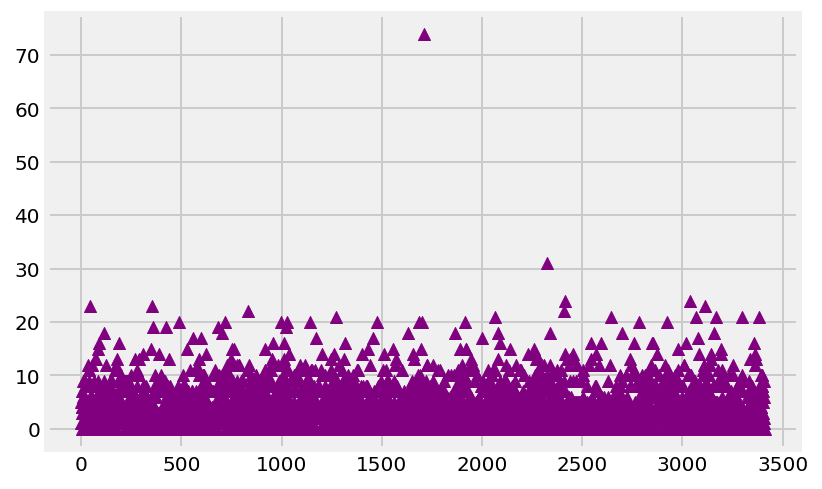

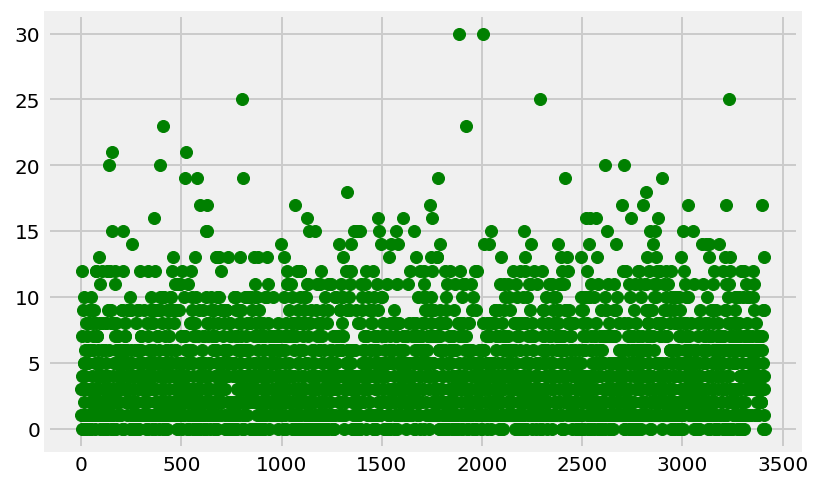

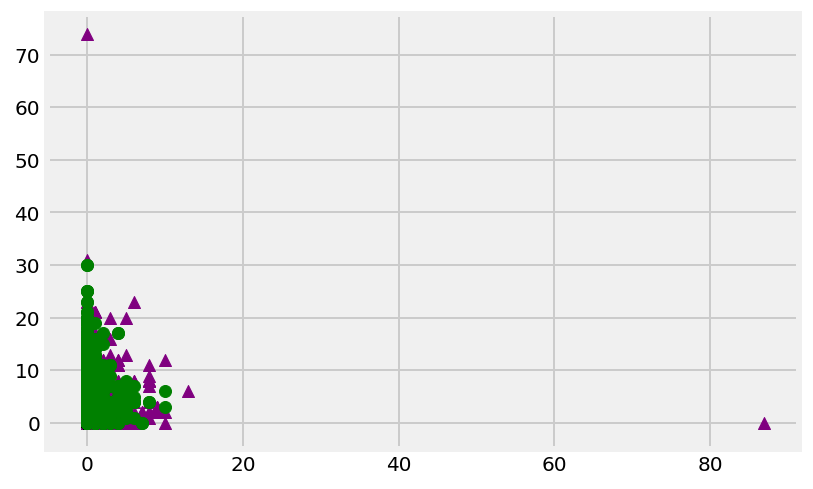

In [287]:
uncleaned_df_puncts= pd.DataFrame()
uncleaned_negs = uncleaned_negative_tweets['count_puncts'].to_list()
uncleaned_pos = uncleaned_positive_tweets['count_puncts'].to_list()
uncleaned_df_puncts['neg_count_puncts'] = uncleaned_negs
uncleaned_df_puncts['pos_count_puncts'] = uncleaned_pos

# uncleaned_x_pos = [i for i in range(18602)]
# uncleaned_x_neg = [i for i in range(18602)]
uncleaned_x_pos = [i for i in range(3411)]
uncleaned_x_neg = [i for i in range(3411)]
plt.scatter(uncleaned_x_pos, uncleaned_pos,marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.show()
plt.scatter(uncleaned_x_neg, uncleaned_negs, marker='o', color = 'green')
plt.show()


# import seaborn as sns
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x="neg_count_puncts", y="pos_count_puncts",fit_reg=False, scatter_kws={'alpha':0.5}, data=uncleaned_df_puncts)
# plt.ylabel('Positive Frequency')
# plt.xlabel('Negative Frequency')
# plt.title('Negative Frequency vs Positive Frequency')   


uncleaned_negss = uncleaned_negative_tweets['count_emoji'].to_list()
uncleaned_poss = uncleaned_positive_tweets['count_emoji'].to_list()

plt.scatter(uncleaned_poss, uncleaned_pos,marker='^', color = 'purple')
#plt.scatter(x_neg, neg_tweets_num_of_words, marker='o')
plt.scatter(uncleaned_negss, uncleaned_negs, marker='o', color = 'green')
plt.show()

In [292]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [238]:
print(uncleaned_count_emoji)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [298]:
from collections import Counter

In [300]:
for tweet in cleaned_tweets:
    wordsList = nltk.word_tokenize(tweet)

    # removing stop words from wordList
    wordsList = [w for w in wordsList if w not in stop_words] 

    #  Using a Tagger. Which is part-of-speech 
    # tagger or POS-tagger. 
    tagged = nltk.pos_tag(wordsList)
    print(tagged)
    counts = Counter( tag for word,  tag in tagged)
    
    print(counts)
    print('\n')

[('us', 'PRP'), ('inside', 'RB'), ('covid', 'VBP'), ('icu', 'JJ'), ('imagine', 'NN'), ('old', 'JJ'), ('colleague', 'NN'), ('reports', 'VBZ'), ('one', 'CD'), ('reality', 'NN'), ('disease', 'NN'), ('going', 'VBG'), ('away', 'RB'), ('anytime', 'RB'), ('soon', 'RB')]
Counter({'RB': 4, 'NN': 4, 'JJ': 2, 'PRP': 1, 'VBP': 1, 'VBZ': 1, 'CD': 1, 'VBG': 1})


[('masks', 'NNS'), ('people', 'NNS'), ('wearing', 'VBG')]
Counter({'NNS': 2, 'VBG': 1})


[('black', 'JJ'), ('peoples', 'NNS'), ('reluctance', 'NN'), ('go', 'VBP'), ('first', 'RB'), ('vaccines', 'RB'), ('despite', 'IN'), ('higher', 'JJR'), ('mortality', 'NN'), ('rate', 'NN'), ('history', 'NN'), ('used', 'VBN'), ('medical', 'JJ'), ('experiments', 'NNS'), ('pm', 'JJ'), ('vaccine', 'NN'), ('approvers', 'NNS'), ('go', 'VBP'), ('first', 'RB'), ('leaderslead', 'JJ')]
Counter({'NN': 5, 'JJ': 4, 'NNS': 3, 'RB': 3, 'VBP': 2, 'IN': 1, 'JJR': 1, 'VBN': 1})


[('biden', 'JJ'), ('administration', 'NN'), ('takes', 'VBZ'), ('office', 'NN'), ('continue', '

[('care', 'NN'), ('explain', 'JJ'), ('thing', 'NN'), ('us', 'PRP'), ('send', 'VBP'), ('kids', 'NNS'), ('school', 'NN'), ('beaten', 'VBP'), ('police', 'NNS'), ('kids', 'NNS'), ('responsible', 'JJ'), ('failure', 'NN'), ('provide', 'VBP'), ('masks', 'NNS'), ('ones', 'NNS'), ('forced', 'VBD'), ('open', 'JJ'), ('schools', 'NNS'), ('pandemic', 'VBP'), ('still', 'RB'), ('ravaging', 'VBG'), ('world', 'NN')]
Counter({'NNS': 6, 'NN': 5, 'VBP': 4, 'JJ': 3, 'PRP': 1, 'VBD': 1, 'RB': 1, 'VBG': 1})


[('check', 'NN'), ('beloved', 'VBD'), ('id', 'JJ'), ('braintrust', 'NN'), ('talking', 'VBG'), ('vaccines', 'NNS'), ('today', 'NN'), ('est', 'VBP'), ('central', 'JJ'), ('register', 'NN')]
Counter({'NN': 4, 'JJ': 2, 'VBD': 1, 'VBG': 1, 'NNS': 1, 'VBP': 1})


[('physically', 'RB'), ('group', 'NN'), ('hug', 'VBD'), ('four', 'CD'), ('sisters', 'NNS')]
Counter({'RB': 1, 'NN': 1, 'VBD': 1, 'CD': 1, 'NNS': 1})


[('increase', 'VB'), ('white', 'JJ'), ('blood', 'NN'), ('cells', 'NNS'), ('potentially', 'RB'), ('sh

[('covid', 'NN'), ('relief', 'NN'), ('package', 'NN'), ('need', 'VBP'), ('direct', 'JJ'), ('payment', 'NN'), ('us', 'PRP'), ('unemployment', 'NN'), ('relief', 'NN'), ('find', 'VBP'), ('job', 'NN'), ('speak', 'JJ'), ('stimulus', 'NN'), ('check', 'VB')]
Counter({'NN': 8, 'VBP': 2, 'JJ': 2, 'PRP': 1, 'VB': 1})


[('healthy', 'JJ'), ('year', 'NN'), ('old', 'JJ'), ('midlothian', 'JJ'), ('man', 'NN'), ('underlying', 'VBG'), ('conditions', 'NNS'), ('dies', 'VBZ'), ('covid', 'NN')]
Counter({'JJ': 3, 'NN': 3, 'VBG': 1, 'NNS': 1, 'VBZ': 1})


[('education', 'NN'), ('health', 'NN'), ('care', 'NN'), ('respect', 'JJ'), ('black', 'JJ'), ('lives', 'VBZ'), ('bodies', 'NNS'), ('minds', 'NNS'), ('matter', 'RBR'), ('thank', 'RB'), ('powerful', 'JJ'), ('message', 'NN'), ('work', 'NN'), ('every', 'DT'), ('day', 'NN'), ('edjustice', 'NN')]
Counter({'NN': 7, 'JJ': 3, 'NNS': 2, 'VBZ': 1, 'RBR': 1, 'RB': 1, 'DT': 1})


[('covid', 'NN'), ('relief', 'NN'), ('package', 'NN'), ('need', 'VBP'), ('direct', 'JJ'), ('

[('big', 'JJ'), ('price', 'NN'), ('paid', 'VBD'), ('towing', 'VBG'), ('american', 'JJ'), ('lives', 'NNS'), ('satisfy', 'VBP'), ('agenda', 'IN'), ('criminal', 'JJ'), ('need', 'NN'), ('help', 'VBP'), ('two', 'CD'), ('months', 'NNS'), ('fired', 'VBN'), ('covid', 'JJ'), ('destroying', 'VBG'), ('cushy', 'NN'), ('lives', 'NNS')]
Counter({'JJ': 4, 'NN': 3, 'NNS': 3, 'VBG': 2, 'VBP': 2, 'VBD': 1, 'IN': 1, 'CD': 1, 'VBN': 1})


[('turn', 'NN'), ('zombies', 'NNS')]
Counter({'NN': 1, 'NNS': 1})


[('machine', 'NN'), ('shops', 'NNS'), ('quickly', 'RB'), ('adapt', 'VBP'), ('covid', 'JJ'), ('easy', 'JJ'), ('task', 'NN'), ('companies', 'NNS'), ('let', 'VBP'), ('innovation', 'NN'), ('shine', 'VB'), ('company', 'NN'), ('adapted', 'VBD'), ('new', 'JJ'), ('rules', 'NNS'), ('regulations', 'NNS'), ('read', 'VBP'), ('fabricator', 'JJ'), ('article', 'NN'), ('information', 'NN')]
Counter({'NN': 6, 'NNS': 4, 'JJ': 4, 'VBP': 3, 'RB': 1, 'VB': 1, 'VBD': 1})


[('know', 'JJ'), ('work', 'NN'), ('please', 'NN'), ('

[('applied', 'VBN'), ('mine', 'NN'), ('first', 'RB'), ('lockdown', 'JJ'), ('got', 'VBD'), ('em', 'JJ'), ('give', 'JJ'), ('lor', 'NN'), ('extra', 'JJ'), ('face', 'NN'), ('tears', 'NNS'), ('joy', 'JJ'), ('face', 'NN'), ('tears', 'NNS'), ('joy', 'VBP')]
Counter({'JJ': 5, 'NN': 4, 'NNS': 2, 'VBN': 1, 'RB': 1, 'VBD': 1, 'VBP': 1})


[('cancel', 'JJ'), ('game', 'NN'), ('give', 'JJ'), ('steelers', 'NNS'), ('win', 'VBP'), ('nonsense', 'NN')]
Counter({'JJ': 2, 'NN': 2, 'NNS': 1, 'VBP': 1})


[('flexed', 'JJ'), ('biceps', 'NNS'), ('medium', 'NN'), ('dark', 'NN'), ('skin', 'FW'), ('tone', 'NN'), ('tce', 'NN'), ('pushups', 'NNS'), ('flexed', 'VBD'), ('biceps', 'NNS'), ('medium', 'NN'), ('dark', 'NN'), ('skin', 'NN'), ('tone', 'NN'), ('help', 'NN'), ('get', 'VB'), ('stronger', 'JJR'), ('ready', 'JJ'), ('change', 'NN'), ('mondays', 'NNS'), ('share', 'NN'), ('thoughts', 'NNS'), ('impact', 'NN'), ('tce', 'VBP'), ('pushup', 'NN'), ('career', 'NN'), ('life', 'NN'), ('business', 'NN'), ('motivation', 'NN

[('south', 'NN'), ('africa', 'NN'), ('blueberries', 'NNS')]
Counter({'NN': 2, 'NNS': 1})


[('slogan', 'JJ'), ('mandate', 'VB'), ('keeping', 'VBG'), ('people', 'NNS'), ('alive', 'VBP'), ('said', 'VBD'), ('cori', 'JJ'), ('bush', 'NN'), ('made', 'VBN'), ('history', 'NN'), ('last', 'JJ'), ('month', 'NN'), ('became', 'VBD'), ('first', 'JJ'), ('black', 'JJ'), ('woman', 'NN'), ('elected', 'VBD'), ('represent', 'NN'), ('missouri', 'NN'), ('congress', 'NN'), ('via', 'IN'), ('obama', 'NNS'), ('right', 'RB'), ('bring', 'VBG'), ('back', 'RP'), ('mental', 'JJ'), ('health', 'NN'), ('workers', 'NNS')]
Counter({'NN': 8, 'JJ': 6, 'NNS': 3, 'VBD': 3, 'VBG': 2, 'VB': 1, 'VBP': 1, 'VBN': 1, 'IN': 1, 'RB': 1, 'RP': 1})


[('called', 'VBN'), ('white', 'JJ'), ('privilege', 'NN')]
Counter({'VBN': 1, 'JJ': 1, 'NN': 1})


[('design', 'NN'), ('prisons', 'NNS'), ('makes', 'VBZ'), ('spread', 'VBP'), ('virus', 'RB'), ('much', 'JJ'), ('harder', 'JJR'), ('control', 'NN')]
Counter({'NN': 2, 'NNS': 1, 'VBZ': 1, 'VBP':

[('lol', 'JJ'), ('complete', 'JJ'), ('opposite', 'NN')]
Counter({'JJ': 2, 'NN': 1})


[('playing', 'VBG'), ('covid', 'NN'), ('shit', 'NN')]
Counter({'NN': 2, 'VBG': 1})


[('get', 'NN'), ('vaccinated', 'VBN'), ('covid', 'NN')]
Counter({'NN': 2, 'VBN': 1})


[('mcconnell', 'NN'), ('claims', 'NNS'), ('time', 'NN'), ('waste', 'NN'), ('time', 'NN'), ('covid', 'JJ'), ('relief', 'NN')]
Counter({'NN': 5, 'NNS': 1, 'JJ': 1})


[('column', 'NN'), ('today', 'NN'), ('let', 'VBD'), ('coronavirus', 'NN'), ('kill', 'VB'), ('christmas', 'JJ'), ('blame', 'JJ'), ('ap', 'NN'), ('style', 'NN'), ('lack', 'NN'), ('oxford', 'NN'), ('commas', 'NN'), ('lowercase', 'NN'), ('headline', 'NN'), ('bad', 'JJ'), ('writing', 'VBG'), ('methods', 'NNS'), ('ap', 'JJ'), ('embraces', 'NNS'), ('face', 'VBP'), ('rolling', 'VBG'), ('eyes', 'NNS')]
Counter({'NN': 10, 'JJ': 4, 'NNS': 3, 'VBG': 2, 'VBD': 1, 'VB': 1, 'VBP': 1})


[('also', 'RB'), ('responded', 'VBD'), ('positively', 'RB'), ('virus', 'JJ'), ('stimulus', 'NN'), ('

[('trump', 'NN'), ('concerned', 'VBN'), ('election', 'NN'), ('winning', 'VBG'), ('ever', 'RB'), ('coronavirus', 'VB'), ('trying', 'VBG'), ('save', 'JJ'), ('american', 'JJ'), ('lives', 'NNS')]
Counter({'NN': 2, 'VBG': 2, 'JJ': 2, 'VBN': 1, 'RB': 1, 'VB': 1, 'NNS': 1})


[('still', 'RB'), ('looking', 'VBG'), ('source', 'NN'), ('income', 'NN'), ('think', 'VBP'), ('traditional', 'JJ'), ('especially', 'RB'), ('tried', 'VBN'), ('amazed', 'JJ'), ('result', 'NN'), ('ebay', 'JJ'), ('sellonline', 'NN'), ('extraincome', 'NN'), ('covid', 'NN'), ('onlineselling', 'VBG'), ('extracash', 'NN')]
Counter({'NN': 7, 'JJ': 3, 'RB': 2, 'VBG': 2, 'VBP': 1, 'VBN': 1})


[('shocked', 'VBN')]
Counter({'VBN': 1})


[('anyway', 'RB'), ('tested', 'VBN'), ('negative', 'JJ'), ('today', 'NN'), ('relieved', 'VBD'), ('face', 'NN')]
Counter({'NN': 2, 'RB': 1, 'VBN': 1, 'JJ': 1, 'VBD': 1})


[('quarantine', 'NN'), ('helped', 'VBD'), ('make', 'VB'), ('sure', 'JJ'), ('learns', 'NNS'), ('needs', 'NNS')]
Counter({'NNS': 2, '

[('thanks', 'NNS'), ('nurse', 'VBP'), ('spirit', 'NN'), ('longer', 'RBR'), ('practice', 'NN'), ('appreciate', 'NN'), ('admin', 'NN'), ('bungled', 'VBN'), ('response', 'NN'), ('pandemic', 'JJ'), ('maga', 'NN'), ('er', 'NN'), ('may', 'MD'), ('brainwashed', 'VB'), ('ironic', 'JJ'), ('suggest', 'NN'), ('therapy', 'NN'), ('view', 'NN'), ('minute', 'NN'), ('cry', 'NN'), ('phycological', 'JJ'), ('help', 'NN'), ('display', 'NN'), ('yesterday', 'NN')]
Counter({'NN': 15, 'JJ': 3, 'NNS': 1, 'VBP': 1, 'RBR': 1, 'VBN': 1, 'MD': 1, 'VB': 1})


[('worlds', 'NNS'), ('first', 'RB'), ('lockdown', 'VBP'), ('party', 'NN')]
Counter({'NNS': 1, 'RB': 1, 'VBP': 1, 'NN': 1})


[('dorit', 'NN'), ('tagline', 'NN'), ('next', 'IN'), ('season', 'NN'), ('sense', 'NN'), ('smell', 'NN'), ('might', 'MD'), ('gone', 'VBN'), ('still', 'RB'), ('impeccable', 'JJ'), ('taste', 'NN')]
Counter({'NN': 6, 'IN': 1, 'MD': 1, 'VBN': 1, 'RB': 1, 'JJ': 1})


[('feel', 'VB'), ('guilty', 'JJ'), ('complain', 'NN'), ('taken', 'VBN'), ('go

[('vaccination', 'NN'), ('choice', 'NN')]
Counter({'NN': 2})


[('gop', 'NN'), ('senate', 'NN'), ('majority', 'NN'), ('shown', 'VBN'), ('truly', 'RB'), ('give', 'JJ'), ('crap', 'NN'), ('covid', 'NN'), ('relief', 'NN'), ('bill', 'NN'), ('assisting', 'VBG'), ('funding', 'NN'), ('state', 'NN'), ('financial', 'JJ'), ('needs', 'VBZ'), ('small', 'JJ'), ('business', 'NN'), ('closures', 'NNS'), ('georgia', 'VBD'), ('home', 'NN'), ('state', 'NN'), ('donated', 'VBD'), ('candidates', 'NNS')]
Counter({'NN': 12, 'JJ': 3, 'NNS': 2, 'VBD': 2, 'VBN': 1, 'RB': 1, 'VBG': 1, 'VBZ': 1})


[('cdc', 'NNS'), ('americans', 'NNS'), ('travel', 'VBP'), ('covid', 'JJ'), ('risky', 'JJ'), ('kenya', 'NN'), ('peril', 'NN')]
Counter({'NNS': 2, 'JJ': 2, 'NN': 2, 'VBP': 1})


[('forget', 'NN'), ('covid', 'NNS'), ('wake', 'VBP'), ('church', 'NN'), ('luke', 'NN'), ('jesus', 'NN'), ('told', 'VBD'), ('let', 'VBN'), ('dead', 'JJ'), ('bury', 'NN'), ('dead', 'JJ'), ('however', 'RB'), ('go', 'VBP'), ('proclaim', 'JJ'), ('kingdo

[('luxurious', 'JJ'), ('face', 'NN'), ('masks', 'NNS'), ('sale', 'NN'), ('japan', 'NN')]
Counter({'NN': 3, 'JJ': 1, 'NNS': 1})


[('vaccine', 'JJ'), ('month', 'NN'), ('away', 'RB'), ('every', 'DT'), ('infection', 'NN'), ('death', 'NN'), ('unnecessary', 'JJ'), ('point', 'NN'), ('defiance', 'NN'), ('becomes', 'VBZ'), ('insanity', 'JJ'), ('maybe', 'RB'), ('building', 'VBG'), ('trump', 'NN'), ('wall', 'NN'), ('wrong', 'JJ'), ('border', 'NN')]
Counter({'NN': 8, 'JJ': 4, 'RB': 2, 'DT': 1, 'VBZ': 1, 'VBG': 1})


[('office', 'NN'), ('fl', 'NN'), ('gov', 'NN'), ('ron', 'NN'), ('desantis', 'NN'), ('announces', 'VBZ'), ('news', 'NN'), ('conference', 'NN'), ('hour', 'NN'), ('notice', 'RB'), ('taken', 'VBN'), ('questions', 'NNS'), ('reporters', 'NNS'), ('weeks', 'NNS'), ('cnn', 'VBP'), ('reports', 'NNS'), ('mayors', 'NNS'), ('miami', 'VBP'), ('miami', 'JJ'), ('beach', 'NN'), ('luck', 'VBD'), ('reaching', 'JJ'), ('days', 'NNS'), ('trying', 'VBG'), ('covid', 'JJ'), ('cases', 'NNS'), ('near', 'IN'), (

[('breaking', 'VBG'), ('taca', 'JJ'), ('american', 'JJ'), ('football', 'NN'), ('combine', 'NN'), ('set', 'VBN'), ('dec', 'NN'), ('oakland', 'NN'), ('postponed', 'VBD'), ('later', 'RBR'), ('date', 'NN'), ('due', 'JJ'), ('rise', 'NN'), ('covid', 'NN'), ('cases', 'NNS'), ('still', 'RB'), ('every', 'DT'), ('intention', 'NN'), ('staging', 'VBG'), ('event', 'NN'), ('safety', 'NN'), ('young', 'JJ'), ('people', 'NNS'), ('top', 'JJ'), ('priority', 'NN'), ('taca', 'NN'), ('exec', 'NN'), ('dir', 'NN'), ('said', 'VBD')]
Counter({'NN': 14, 'JJ': 5, 'VBG': 2, 'VBD': 2, 'NNS': 2, 'VBN': 1, 'RBR': 1, 'RB': 1, 'DT': 1})


[('plan', 'NN'), ('try', 'VB'), ('schedule', 'NN'), ('holidays', 'NNS'), ('depending', 'VBG'), ('course', 'NN'), ('covid', 'NN'), ('cases', 'NNS'), ('maskup', 'VBP'), ('please', 'NN')]
Counter({'NN': 5, 'NNS': 2, 'VB': 1, 'VBG': 1, 'VBP': 1})


[('pandemic', 'NN')]
Counter({'NN': 1})


[('problem', 'NN'), ('irresponsible', 'JJ'), ('people', 'NNS'), ('businesses', 'NNS'), ('making', 'V

[('scott', 'NN'), ('atlas', 'NNS'), ('trump', 'VBP'), ('coronavirus', 'NN'), ('adviser', 'NN'), ('resigns', 'NNS'), ('report', 'VBP'), ('washington', 'NN'), ('times', 'NNS')]
Counter({'NN': 4, 'NNS': 3, 'VBP': 2})


[('kids', 'NNS'), ('school', 'NN'), ('today', 'NN'), ('tomorrow', 'NN'), ('skeptical', 'JJ'), ('school', 'NN'), ('reopen', 'JJ'), ('wednesday', 'NN'), ('skeptical', 'JJ')]
Counter({'NN': 5, 'JJ': 3, 'NNS': 1})


[('god', 'NN'), ('sad', 'JJ'), ('blessings', 'NNS'), ('folded', 'VBD'), ('hands', 'NNS'), ('medium', 'JJ'), ('dark', 'JJ'), ('skin', 'NN'), ('tone', 'NN')]
Counter({'NN': 3, 'JJ': 3, 'NNS': 2, 'VBD': 1})


[('able', 'JJ'), ('tell', 'NN')]
Counter({'JJ': 1, 'NN': 1})


[('birthday', 'JJ'), ('wealth', 'NN'), ('health', 'NN'), ('god', 'NN'), ('bless', 'NN'), ('enjoy', 'VBP'), ('balloon', 'NN'), ('party', 'NN'), ('popper', 'NN'), ('confetti', 'NN'), ('ball', 'NN'), ('wrapped', 'VBD'), ('gift', 'NN'), ('endsars', 'NNS'), ('wearamask', 'VBP'), ('face', 'VBP'), ('medical',

[('someone', 'NN'), ('say', 'VBP'), ('automation', 'NN')]
Counter({'NN': 2, 'VBP': 1})


[('mumbai', 'NN'), ('traffic', 'NN'), ('jams', 'NNS'), ('shown', 'VBN'), ('efficacy', 'NN'), ('corona', 'NN'), ('virus', 'NN')]
Counter({'NN': 5, 'NNS': 1, 'VBN': 1})


[('oregon', 'NN'), ('nurse', 'NN'), ('bragged', 'VBD'), ('tiktok', 'JJ'), ('wearing', 'VBG'), ('mask', 'NN'), ('outside', 'JJ'), ('work', 'NN'), ('administrative', 'JJ'), ('leave', 'VBP'), ('washington', 'VBN'), ('post', 'NN'), ('stupid', 'JJ'), ('games', 'NNS')]
Counter({'NN': 5, 'JJ': 4, 'VBD': 1, 'VBG': 1, 'VBP': 1, 'VBN': 1, 'NNS': 1})


[('barexam', 'NN'), ('questions', 'NNS'), ('cut', 'VBD'), ('half', 'JJ'), ('online', 'JJ'), ('exam', 'NN'), ('due', 'JJ'), ('covid', 'NN'), ('info', 'JJ'), ('number', 'NN'), ('questions', 'NNS'), ('tested', 'VBD')]
Counter({'NN': 4, 'JJ': 4, 'NNS': 2, 'VBD': 2})


[('aviation', 'NN'), ('psychology', 'NN'), ('idea', 'NN'), ('came', 'VBD'), ('mitigate', 'JJ'), ('coronavirus', 'NN'), ('maybe', 'RB'

[('mcconnell', 'NN'), ('knows', 'VBZ'), ('unrealistic', 'JJ'), ('hurry', 'NN'), ('pass', 'NN'), ('tax', 'NN'), ('cut', 'NN'), ('mills', 'NNS'), ('bills', 'NNS'), ('lacks', 'VBZ'), ('interest', 'NN'), ('help', 'NN'), ('poor', 'JJ'), ('unemployed', 'JJ'), ('small', 'JJ'), ('businesses', 'NNS')]
Counter({'NN': 7, 'JJ': 4, 'NNS': 3, 'VBZ': 2})


[('sometimes', 'RB'), ('getting', 'VBG'), ('really', 'RB'), ('dark', 'JJ'), ('day', 'NN'), ('working', 'VBG'), ('home', 'NN'), ('people', 'NNS'), ('dealing', 'VBG'), ('desk', 'NN'), ('lamps', 'NNS')]
Counter({'VBG': 3, 'NN': 3, 'RB': 2, 'NNS': 2, 'JJ': 1})


[]
Counter()


[('swedish', 'JJ'), ('coronasverige', 'NN'), ('policy', 'NN'), ('let', 'VBD'), ('unknown', 'JJ'), ('virus', 'NNS'), ('spread', 'VBP'), ('herd', 'JJ'), ('cull', 'NN'), ('weak', 'JJ'), ('feeble', 'JJ'), ('elderly', 'JJ'), ('pensioners', 'NNS'), ('resulting', 'VBG'), ('less', 'JJ'), ('government', 'NN'), ('payout', 'NN'), ('budget', 'NN'), ('opens', 'VBZ'), ('apartments', 'NNS'), ('

[('army', 'RB'), ('arrive', 'JJ'), ('bristol', 'NN'), ('stadium', 'NN'), ('covid', 'JJ'), ('vaccine', 'NN'), ('roll', 'NN'), ('due', 'JJ'), ('start', 'RB'), ('next', 'JJ'), ('week', 'NN')]
Counter({'NN': 5, 'JJ': 4, 'RB': 2})


[('oh', 'UH'), ('man', 'NN')]
Counter({'UH': 1, 'NN': 1})


[('covid', 'NN'), ('tiers', 'NNS'), ('vote', 'VBP'), ('vulnerable', 'JJ'), ('children', 'NNS'), ('christmas', 'VBP'), ('tree', 'NN'), ('boom', 'NN')]
Counter({'NN': 3, 'NNS': 2, 'VBP': 2, 'JJ': 1})


[('delivery', 'NN'), ('secretariat', 'NN'), ('plans', 'NNS'), ('increase', 'VBP'), ('number', 'NN'), ('projects', 'NNS'), ('publicprivate', 'VBP'), ('partnerships', 'NNS'), ('ppps', 'NN'), ('sources', 'NNS'), ('funds', 'NNS'), ('dwindle', 'VBP'), ('following', 'VBG'), ('among', 'IN'), ('reasons', 'NNS'), ('outbreak', 'VBP'), ('covid', 'JJ'), ('pandemic', 'JJ'), ('vision', 'NN'), ('oncourse', 'NN')]
Counter({'NN': 6, 'NNS': 6, 'VBP': 4, 'JJ': 2, 'VBG': 1, 'IN': 1})


[('city', 'NN'), ('state', 'NN'), ('gover

[('fast', 'RB'), ('politicians', 'NNS'), ('scientists', 'NNS'), ('good', 'JJ'), ('thing', 'NN'), ('fast', 'JJ'), ('public', 'JJ'), ('means', 'VBZ'), ('hmm', 'JJ'), ('something', 'NN'), ('something', 'NN'), ('fishy', 'JJ'), ('vaccine', 'NN'), ('confidence', 'NN'), ('project', 'NN'), ('via', 'IN')]
Counter({'NN': 6, 'JJ': 5, 'NNS': 2, 'RB': 1, 'VBZ': 1, 'IN': 1})


[('covid', 'JJ'), ('new', 'JJ'), ('pfizer', 'NN'), ('vaccine', 'NN'), ('work', 'NN')]
Counter({'NN': 3, 'JJ': 2})


[('probably', 'RB'), ('quite', 'RB')]
Counter({'RB': 2})


[('employers', 'NNS'), ('start', 'VBP'), ('preparing', 'VBG'), ('coronavirus', 'NN'), ('vaccine', 'JJ'), ('question', 'NN'), ('require', 'NN')]
Counter({'NN': 3, 'NNS': 1, 'VBP': 1, 'VBG': 1, 'JJ': 1})


[('fearful', 'JJ'), ('dreams', 'NNS'), ('vaccine', 'VBP'), ('cure', 'NN'), ('detrimental', 'JJ'), ('impacts', 'NNS'), ('control', 'VBP'), ('pandemic', 'JJ'), ('could', 'MD'), ('control', 'VB'), ('spread', 'JJ'), ('covid', 'NN'), ('right', 'RB'), ('fully',

[('say', 'VB'), ('lightly', 'RB'), ('republican', 'JJ'), ('leaders', 'NNS'), ('core', 'VBP'), ('beliefs', 'NNS'), ('white', 'JJ'), ('supremacy', 'NN'), ('money', 'NN'), ('survival', 'NN'), ('fittest', 'JJS'), ('population', 'NN'), ('control', 'NN'), ('makers', 'NNS'), ('takers', 'NNS'), ('socsec', 'VBP'), ('medicare', 'VBN'), ('civil', 'JJ'), ('rights', 'NNS'), ('covid', 'NN'), ('help', 'NN'), ('control', 'VB'), ('small', 'JJ'), ('biz', 'NNS'), ('support', 'NN'), ('let', 'VBD'), ('die', 'NNS'), ('make', 'VB'), ('keep', 'JJ'), ('power', 'NN')]
Counter({'NN': 9, 'NNS': 7, 'JJ': 5, 'VB': 3, 'VBP': 2, 'RB': 1, 'JJS': 1, 'VBN': 1, 'VBD': 1})


[('people', 'NNS'), ('thought', 'VBD'), ('sexy', 'JJ'), ('futuristic', 'JJ'), ('role', 'NN'), ('play', 'NN'), ('would', 'MD'), ('robotic', 'VB'), ('disguises', 'NNS'), ('little', 'RB'), ('know', 'VBP'), ('blue', 'JJ'), ('black', 'JJ'), ('face', 'NN'), ('mask', 'NN')]
Counter({'JJ': 4, 'NN': 4, 'NNS': 2, 'VBD': 1, 'MD': 1, 'VB': 1, 'RB': 1, 'VBP': 1})


[('gon', 'NN'), ('na', 'TO'), ('see', 'VB'), ('numbers', 'NNS'), ('like', 'IN'), ('place', 'NN'), ('michigan', 'JJ'), ('shares', 'NNS'), ('border', 'VBP'), ('ohio', 'IN'), ('expect', 'JJ'), ('numbers', 'NNS'), ('follow', 'VBP'), ('suit', 'NN'), ('know', 'VBP'), ('sit', 'NN'), ('follow', 'JJ'), ('directions', 'NNS'), ('shit', 'VBP'), ('crazy', 'JJ')]
Counter({'NN': 4, 'NNS': 4, 'JJ': 4, 'VBP': 4, 'IN': 2, 'TO': 1, 'VB': 1})


[('important', 'JJ'), ('thing', 'NN'), ('see', 'VB'), ('sounds', 'VBZ'), ('rough', 'JJ'), ('around', 'IN'), ('edges', 'JJ'), ('government', 'NN'), ('done', 'VBN'), ('right', 'JJ'), ('thing', 'NN'), ('beginning', 'VBG'), ('people', 'NNS'), ('would', 'MD'), ('willing', 'JJ'), ('stay', 'VB'), ('home', 'RB'), ('dumb', 'JJ'), ('think', 'VBP'), ('shut', 'VBN'), ('family', 'NN'), ('income', 'NN'), ('really', 'RB'), ('assistance', 'VB')]
Counter({'JJ': 6, 'NN': 5, 'VB': 3, 'VBN': 2, 'RB': 2, 'VBZ': 1, 'IN': 1, 'VBG': 1, 'NNS': 1, 'MD': 1, 'VBP': 1})


[('gon', 'NN'), ('na'

[('covid', 'NNS'), ('profiteer', 'NN')]
Counter({'NNS': 1, 'NN': 1})


[('agree', 'JJ'), ('vaccine', 'NN'), ('sole', 'JJ'), ('mechanism', 'NN'), ('control', 'NN'), ('pandemic', 'JJ')]
Counter({'JJ': 3, 'NN': 3})


[('age', 'NN'), ('covid', 'NN'), ('quarantine', 'NN'), ('marketing', 'NN'), ('necessary', 'JJ')]
Counter({'NN': 4, 'JJ': 1})


[('get', 'VB'), ('hella', 'NN'), ('cold', 'JJ'), ('hopefully', 'RB'), ('drops', 'VBZ'), ('tf', 'NN'), ('covid', 'NN'), ('numbers', 'NNS'), ('get', 'VBP'), ('back', 'RB'), ('regular', 'JJ'), ('life', 'NN')]
Counter({'NN': 4, 'JJ': 2, 'RB': 2, 'VB': 1, 'VBZ': 1, 'NNS': 1, 'VBP': 1})


[('congrats', 'NNS'), ('kyle', 'VBP'), ('momma', 'JJ'), ('jennifer', 'NN'), ('must', 'MD'), ('happy', 'VB'), ('red', 'JJ'), ('heart', 'NN'), ('folded', 'VBD'), ('hands', 'NNS'), ('medium', 'JJ'), ('dark', 'JJ'), ('skin', 'NN'), ('tone', 'NN')]
Counter({'JJ': 4, 'NN': 4, 'NNS': 2, 'VBP': 1, 'MD': 1, 'VB': 1, 'VBD': 1})


[('coronavirus', 'NN'), ('numbers', 'NNS')]
Counter({

[('england', 'VB'), ('new', 'JJ'), ('three', 'CD'), ('tier', 'NN'), ('system', 'NN'), ('comes', 'VBZ'), ('effect', 'NN'), ('december', 'NN'), ('non', 'JJ'), ('essential', 'JJ'), ('shops', 'NNS'), ('areas', 'NNS'), ('reopen', 'VBP'), ('gyms', 'NN'), ('hairdressers', 'NNS'), ('personal', 'JJ'), ('care', 'NN'), ('businesses', 'NNS'), ('rule', 'VBP'), ('six', 'CD'), ('apply', 'RB'), ('outdoor', 'JJ'), ('gatherings', 'NNS'), ('areas', 'NNS')]
Counter({'NN': 6, 'NNS': 6, 'JJ': 5, 'CD': 2, 'VBP': 2, 'VB': 1, 'VBZ': 1, 'RB': 1})


[('india', 'JJ'), ('daily', 'JJ'), ('covid', 'NN'), ('cases', 'NNS'), ('continued', 'VBD'), ('stay', 'JJ'), ('mark', 'NN'), ('th', 'NN'), ('straight', 'VBD'), ('day', 'NN'), ('new', 'JJ'), ('infections', 'NNS'), ('reported', 'VBN'), ('wednesday', 'JJ'), ('country', 'NN'), ('million', 'CD'), ('total', 'JJ'), ('cases', 'NNS')]
Counter({'JJ': 6, 'NN': 5, 'NNS': 3, 'VBD': 2, 'VBN': 1, 'CD': 1})


[('one', 'CD'), ('typo', 'NN'), ('see', 'NN'), ('carnage', 'NN'), ('unleash

[('stat', 'NN'), ('learned', 'VBD'), ('senior', 'JJ'), ('leaders', 'NNS'), ('trump', 'VBP'), ('admin', 'RB'), ('covid', 'JJ'), ('task', 'NN'), ('force', 'NN'), ('pressing', 'VBG'), ('adults', 'NNS'), ('older', 'JJR'), ('given', 'VBN'), ('first', 'JJ'), ('access', 'NN'), ('vaccine', 'NN'), ('approach', 'NN'), ('contradicts', 'VBZ'), ('position', 'NN'), ('committee', 'NN'), ('advises', 'VBZ'), ('cdc', 'JJ'), ('vaccine', 'NN'), ('policy', 'NN'), ('may', 'MD'), ('recommend', 'VB'), ('hcp', 'NN'), ('front', 'JJ'), ('vaccination', 'NN'), ('line', 'NN')]
Counter({'NN': 13, 'JJ': 5, 'NNS': 2, 'VBZ': 2, 'VBD': 1, 'VBP': 1, 'RB': 1, 'VBG': 1, 'JJR': 1, 'VBN': 1, 'MD': 1, 'VB': 1})


[('part', 'NN')]
Counter({'NN': 1})


[('ramen', 'NNS'), ('noodles', 'NNS'), ('brains', 'NNS')]
Counter({'NNS': 3})


[('congrats', 'NNS')]
Counter({'NNS': 1})


[('probably', 'RB'), ('covid', 'NN')]
Counter({'RB': 1, 'NN': 1})


[('salutations', 'NNS'), ('uk', 'JJ'), ('festival', 'JJ'), ('live', 'JJ'), ('industry', 

[('coronavirus', 'NN'), ('hackers', 'NNS'), ('targeted', 'VBD'), ('covid', 'JJ'), ('vaccine', 'NN'), ('supply', 'NN'), ('cold', 'NN'), ('chain', 'NN')]
Counter({'NN': 5, 'NNS': 1, 'VBD': 1, 'JJ': 1})


[('suppose', 'JJ'), ('trust', 'NN'), ('receiving', 'VBG'), ('covidvaccine', 'NN'), ('vaccine', 'NN'), ('everyone', 'NN'), ('receive', 'JJ'), ('vaccine', 'NN'), ('ihateithere', 'RB'), ('obama', 'JJ'), ('bush', 'JJ'), ('clinton', 'NN'), ('say', 'VBP'), ('take', 'VB'), ('covid', 'JJ'), ('vaccine', 'NN'), ('publicly', 'RB'), ('gain', 'VBZ'), ('public', 'JJ'), ('trust', 'NN')]
Counter({'NN': 8, 'JJ': 6, 'RB': 2, 'VBG': 1, 'VBP': 1, 'VB': 1, 'VBZ': 1})


[('long', 'RB'), ('thread', 'JJ'), ('one', 'CD'), ('worth', 'NN'), ('reading', 'NN')]
Counter({'NN': 2, 'RB': 1, 'JJ': 1, 'CD': 1})


[('right', 'RB'), ('stfu', 'NN')]
Counter({'RB': 1, 'NN': 1})


[('drops', 'NNS'), ('mic', 'VBP')]
Counter({'NNS': 1, 'VBP': 1})


[('bunch', 'NN'), ('spoiled', 'VBD'), ('stupid', 'JJ'), ('people', 'NNS'), ('ask

[('ppl', 'NN'), ('gon', 'NN'), ('na', 'TO'), ('become', 'VB'), ('non', 'JJ'), ('obese', 'JJ'), ('immediately', 'RB'), ('time', 'NN'), ('die', 'NN'), ('covid', 'NN')]
Counter({'NN': 5, 'JJ': 2, 'TO': 1, 'VB': 1, 'RB': 1})


[('trials', 'NNS'), ('normal', 'JJ'), ('length', 'JJ'), ('testing', 'VBG'), ('nothing', 'NN'), ('sped', 'VBD'), ('one', 'CD'), ('death', 'NN'), ('whole', 'NN'), ('study', 'NN'), ('someone', 'NN'), ('get', 'VBP'), ('vaccine', 'NN')]
Counter({'NN': 6, 'JJ': 2, 'NNS': 1, 'VBG': 1, 'VBD': 1, 'CD': 1, 'VBP': 1})


[('makes', 'VBZ'), ('body', 'NN'), ('create', 'JJ'), ('antibodies', 'NNS'), ('way', 'NN'), ('flu', 'JJ'), ('vaccine', 'NN'), ('actually', 'RB'), ('safe', 'JJ'), ('flu', 'JJ'), ('vaccine', 'NN'), ('live', 'VBP'), ('virus', 'NN')]
Counter({'NN': 5, 'JJ': 4, 'VBZ': 1, 'NNS': 1, 'RB': 1, 'VBP': 1})


[('still', 'RB'), ('democracy', 'NN'), ('thumbs', 'JJ'), ('medium', 'NN'), ('skin', 'NN'), ('tone', 'NN')]
Counter({'NN': 4, 'RB': 1, 'JJ': 1})


[('yeah', 'RB'), ('one

[('weird', 'JJ'), ('war', 'NN'), ('nyc', 'NN'), ('parts', 'NNS'), ('jewish', 'JJ'), ('community', 'NN'), ('since', 'IN'), ('pandemic', 'NN'), ('started', 'VBD'), ('mayor', 'NN'), ('gov', 'NN'), ('handled', 'VBN'), ('well', 'RB'), ('alot', 'JJ'), ('deaths', 'NNS'), ('came', 'VBD'), ('community', 'NN'), ('confusing', 'VBG'), ('fighting', 'VBG'), ('restrictions', 'NNS'), ('hard', 'RB')]
Counter({'NN': 7, 'JJ': 3, 'NNS': 3, 'VBD': 2, 'RB': 2, 'VBG': 2, 'IN': 1, 'VBN': 1})


[('yup', 'RB'), ('usaeducationalsystemisbroke', 'JJ'), ('fair', 'NN'), ('trumprally', 'RB'), ('consider', 'VB'), ('may', 'MD'), ('gotten', 'VB'), ('morevotesthananysittingpres', 'NNS'), ('appears', 'VBZ'), ('gotten', 'JJ'), ('seventythreemillionvotes', 'NNS'), ('appears', 'VBZ'), ('still', 'RB'), ('lost', 'VBN'), ('opponent', 'NN'), ('got', 'VBD'), ('millionmorevotes', 'NNS'), ('thinking', 'VBG'), ('face', 'NN')]
Counter({'RB': 3, 'NN': 3, 'NNS': 3, 'JJ': 2, 'VB': 2, 'VBZ': 2, 'MD': 1, 'VBN': 1, 'VBD': 1, 'VBG': 1})


[

[('point', 'NN'), ('treat', 'NN'), ('teams', 'NNS'), ('like', 'IN'), ('adults', 'NNS'), ('make', 'VBP'), ('team', 'NN'), ('forfeit', 'NN'), ('game', 'NN'), ('follow', 'VBP'), ('covid', 'NN'), ('protocol', 'NN'), ('crazy', 'NN')]
Counter({'NN': 8, 'NNS': 2, 'VBP': 2, 'IN': 1})


[('nz', 'NN'), ('showed', 'VBD'), ('world', 'NN'), ('following', 'VBG'), ('science', 'NN'), ('business', 'NN'), ('lobby', 'NN'), ('contained', 'VBD'), ('covid', 'JJ'), ('time', 'NN'), ('climate', 'NN'), ('change', 'NN'), ('palaeoclimatology', 'NN'), ('science', 'NN'), ('projected', 'VBD'), ('end', 'NN'), ('point', 'NN'), ('far', 'RB'), ('serious', 'JJ'), ('covid', 'NNS'), ('pandemic', 'VBP')]
Counter({'NN': 12, 'VBD': 3, 'JJ': 2, 'VBG': 1, 'RB': 1, 'NNS': 1, 'VBP': 1})


[('michigan', 'JJ'), ('couple', 'NN'), ('married', 'VBD'), ('years', 'NNS'), ('die', 'JJ'), ('covid', 'JJ'), ('day', 'NN'), ('smartnews', 'NNS')]
Counter({'JJ': 3, 'NN': 2, 'NNS': 2, 'VBD': 1})


[('must', 'MD'), ('read', 'VB'), ('covid', 'NN'),

[('voted', 'JJ'), ('pay', 'NN'), ('nurses', 'NNS'), ('midwives', 'VBZ'), ('pandemic', 'JJ'), ('shut', 'NN'), ('scum', 'NN')]
Counter({'NN': 3, 'JJ': 2, 'NNS': 1, 'VBZ': 1})


[('fine', 'JJ'), ('enough', 'RB'), ('people', 'NNS'), ('stupid', 'JJ'), ('achieve', 'VBP'), ('herd', 'NN'), ('immunity', 'NN'), ('virus', 'NN'), ('rage', 'NN'), ('unvaccinated', 'VBD'), ('every', 'DT'), ('winter', 'NN'), ('enough', 'JJ'), ('people', 'NNS'), ('persuaded', 'VBD'), ('get', 'NN'), ('vaccinated', 'VBN'), ('die', 'JJ'), ('choice', 'NN')]
Counter({'NN': 7, 'JJ': 4, 'NNS': 2, 'VBD': 2, 'RB': 1, 'VBP': 1, 'DT': 1, 'VBN': 1})


[('professor', 'NN'), ('mccarrm', 'NN'), ('key', 'JJ'), ('gaps', 'NNS'), ('knowledge', 'VBP'), ('include', 'VBP'), ('need', 'VBP'), ('covid', 'JJ'), ('follow', 'VBP'), ('research', 'NN'), ('need', 'NN'), ('avoid', 'VBP'), ('using', 'VBG'), ('chronological', 'JJ'), ('age', 'NN'), ('need', 'VBP'), ('closely', 'RB'), ('monitor', 'JJ'), ('effects', 'NNS'), ('vaccine', 'VBP'), ('rolled', 

[('london', 'JJ'), ('mayor', 'NN'), ('political', 'JJ'), ('aide', 'NN'), ('working', 'VBG'), ('home', 'NN'), ('san', 'NN'), ('francisco', 'NN'), ('via', 'IN')]
Counter({'NN': 5, 'JJ': 2, 'VBG': 1, 'IN': 1})


[('texas', 'NNS'), ('bud', 'JJ'), ('way', 'NN'), ('business', 'NN'), ('markets', 'NNS'), ('success', 'NN'), ('covid', 'VBP'), ('innovation', 'NN'), ('america', 'NN'), ('finance', 'NN'), ('startups', 'VBD'), ('money', 'NN'), ('stocks', 'NNS'), ('usa', 'VBP'), ('investing', 'VBG'), ('privateequity', 'NN'), ('economy', 'NN'), ('recession', 'NN'), ('coronavirus', 'NN'), ('chicago', 'NN'), ('newyork', 'NN'), ('ethereum', 'NN'), ('china', 'NN'), ('weed', 'NN')]
Counter({'NN': 16, 'NNS': 3, 'VBP': 2, 'JJ': 1, 'VBD': 1, 'VBG': 1})


[('covid', 'NN'), ('kills', 'NNS'), ('look', 'VBP'), ('side', 'JJ'), ('effects', 'NNS'), ('aspirin', 'VBP'), ('co', 'NN'), ('codamal', 'NN')]
Counter({'NN': 3, 'NNS': 2, 'VBP': 2, 'JJ': 1})


[('post', 'NN'), ('covid', 'NN'), ('go', 'VBP'), ('see', 'VB'), ('li

[('worse', 'JJR'), ('oppose', 'JJ'), ('lockdowns', 'NNS'), ('basic', 'JJ'), ('measures', 'NNS'), ('help', 'VBP'), ('avoid', 'VB'), ('shorten', 'JJ'), ('stricter', 'NN'), ('lockdowns', 'NNS'), ('masks', 'NNS'), ('contact', 'VBP'), ('tracing', 'VBG'), ('communism', 'NN'), ('work', 'NN'), ('friend', 'NN'), ('mine', 'NN'), ('said', 'VBD'), ('testing', 'JJ'), ('waste', 'NN'), ('money', 'NN'), ('price', 'NN'), ('gouging', 'VBG'), ('good', 'JJ'), ('even', 'RB'), ('ppe', 'VBP')]
Counter({'NN': 8, 'JJ': 5, 'NNS': 4, 'VBP': 3, 'VBG': 2, 'JJR': 1, 'VB': 1, 'VBD': 1, 'RB': 1})


[('covid', 'JJ'), ('hospitalizations', 'NNS'), ('california', 'VBP'), ('accelerating', 'VBG'), ('fast', 'RB'), ('ever', 'RB'), ('twice', 'RB'), ('bad', 'JJ'), ('summertime', 'NN'), ('surge', 'NN')]
Counter({'RB': 3, 'JJ': 2, 'NN': 2, 'NNS': 1, 'VBP': 1, 'VBG': 1})


[('vaccine', 'JJ'), ('months', 'NNS'), ('source', 'NN'), ('identified', 'VBN'), ('miracle', 'NN'), ('lol', 'NN')]
Counter({'NN': 3, 'JJ': 1, 'NNS': 1, 'VBN': 1

[('covid', 'JJ'), ('vaccine', 'JJ'), ('side', 'NN'), ('effects', 'NNS'), ('like', 'IN'), ('mild', 'NN'), ('symptoms', 'NNS'), ('need', 'VBP'), ('booster', 'RB'), ('within', 'IN'), ('weeks', 'NNS'), ('talk', 'VBP'), ('please', 'VB'), ('get', 'VB'), ('info', 'JJ'), ('people', 'NNS'), ('need', 'VBP'), ('acclimate', 'JJ'), ('idea', 'NN'), ('process', 'NN'), ('etc', 'FW'), ('pass', 'NN')]
Counter({'NN': 5, 'JJ': 4, 'NNS': 4, 'VBP': 3, 'IN': 2, 'VB': 2, 'RB': 1, 'FW': 1})


[('actually', 'RB'), ('santa', 'JJ'), ('clara', 'JJ'), ('county', 'NN'), ('poster', 'NN'), ('child', 'NN'), ('communism', 'NN'), ('refusing', 'VBG'), ('acknowledge', 'VBP'), ('live', 'JJ'), ('free', 'JJ'), ('society', 'NN'), ('constitutional', 'JJ'), ('rights', 'NNS'), ('good', 'JJ'), ('try', 'NN')]
Counter({'JJ': 6, 'NN': 6, 'RB': 1, 'VBG': 1, 'VBP': 1, 'NNS': 1})


[('god', 'NN'), ('knew', 'VBD'), ('effected', 'JJ'), ('little', 'JJ'), ('guy', 'NN'), ('pandemic', 'NN'), ('would', 'MD'), ('never', 'RB'), ('gotten', 'VB'),

[('questions', 'NNS'), ('submitted', 'VBD'), ('advance', 'NN'), ('covid', 'NN'), ('affected', 'VBD'), ('disabled', 'JJ'), ('people', 'NNS'), ('ellen', 'VBP'), ('suggests', 'VBZ'), ('inquiry', 'JJ'), ('number', 'NN'), ('deaths', 'NNS')]
Counter({'NNS': 3, 'NN': 3, 'VBD': 2, 'JJ': 2, 'VBP': 1, 'VBZ': 1})


[('richard', 'NN'), ('rieser', 'NN'), ('adds', 'VBZ'), ('referencing', 'VBG'), ('recent', 'JJ'), ('report', 'NN'), ('showing', 'VBG'), ('people', 'NNS'), ('learning', 'VBG'), ('disabilities', 'NNS'), ('significantly', 'RB'), ('risk', 'VBP'), ('covid', 'JJ'), ('death', 'NN'), ('rate', 'NN'), ('general', 'JJ'), ('population', 'NN')]
Counter({'NN': 6, 'VBG': 3, 'JJ': 3, 'NNS': 2, 'VBZ': 1, 'RB': 1, 'VBP': 1})


[('yet', 'RB'), ('another', 'DT')]
Counter({'RB': 1, 'DT': 1})


[('nih', 'RB'), ('nothing', 'NN'), ('guidelines', 'NNS'), ('killing', 'VBG'), ('people', 'NNS'), ('lot', 'VBP'), ('people', 'NNS'), ('die', 'VBP'), ('hcq', 'JJ'), ('early', 'JJ'), ('outpatient', 'NN'), ('treatment', '

[('agree', 'NN')]
Counter({'NN': 1})


[('working', 'VBG'), ('home', 'NN'), ('sinus', 'NN'), ('infection', 'NN'), ('better', 'RBR'), ('working', 'VBG'), ('office', 'NN'), ('one', 'CD'), ('eh', 'NN'), ('much', 'JJ'), ('rather', 'RB'), ('tucked', 'VBD'), ('bed', 'NNS'), ('right', 'JJ')]
Counter({'NN': 5, 'VBG': 2, 'JJ': 2, 'RBR': 1, 'CD': 1, 'RB': 1, 'VBD': 1, 'NNS': 1})


[('went', 'VBD'), ('work', 'NN'), ('studio', 'NN'), ('backed', 'VBD'), ('startup', 'JJ'), ('beginning', 'VBG'), ('pandemic', 'JJ'), ('focused', 'JJ'), ('corporate', 'JJ'), ('innovation', 'NN'), ('unfortunately', 'RB'), ('work', 'NN'), ('like', 'IN'), ('model', 'NN')]
Counter({'NN': 5, 'JJ': 4, 'VBD': 2, 'VBG': 1, 'RB': 1, 'IN': 1})


[('great', 'JJ'), ('thing', 'NN'), ('wearing', 'VBG'), ('masks', 'NNS'), ('winter', 'NN'), ('never', 'RB'), ('chapstick', 'NN')]
Counter({'NN': 3, 'JJ': 1, 'VBG': 1, 'NNS': 1, 'RB': 1})


[('sweet', 'JJ'), ('sweet', 'JJ'), ('american', 'JJ'), ('dream', 'NN'), ('living', 'NN')]
Counter({'JJ

[('like', 'IN'), ('pro', 'JJ'), ('vaxxers', 'NNS'), ('tell', 'VBP'), ('avs', 'RB'), ('mistaken', 'VBN'), ('child', 'JJ'), ('injury', 'NN'), ('come', 'VBN'), ('vaccines', 'NNS'), ('oh', 'IN'), ('wait', 'NN')]
Counter({'IN': 2, 'JJ': 2, 'NNS': 2, 'VBN': 2, 'NN': 2, 'VBP': 1, 'RB': 1})


[('pandemic', 'JJ'), ('mean', 'NN'), ('last', 'JJ'), ('months', 'NNS'), ('pandemic', 'JJ'), ('mean', 'JJ'), ('last', 'JJ'), ('years', 'NNS'), ('worried', 'VBD'), ('face', 'NN')]
Counter({'JJ': 5, 'NN': 2, 'NNS': 2, 'VBD': 1})


[('nyc', 'RB'), ('iconic', 'JJ'), ('rockefeller', 'NN'), ('center', 'NN'), ('christmas', 'NN'), ('tree', 'NN'), ('viewing', 'VBG'), ('comes', 'VBZ'), ('tight', 'RB'), ('covid', 'JJ'), ('restrictions', 'NNS')]
Counter({'NN': 4, 'RB': 2, 'JJ': 2, 'VBG': 1, 'VBZ': 1, 'NNS': 1})


[('front', 'JJ'), ('page', 'NN')]
Counter({'JJ': 1, 'NN': 1})


[('herd', 'NN'), ('immunity', 'NN'), ('deja', 'NN'), ('vu', 'NN'), ('higher', 'JJR'), ('seasonal', 'JJ')]
Counter({'NN': 4, 'JJR': 1, 'JJ': 1})


[('december', 'NN'), ('st', 'NN'), ('grateful', 'JJ'), ('festive', 'JJ'), ('mask', 'NN'), ('wearing', 'VBG'), ('season', 'NN'), ('silverlinings', 'NNS')]
Counter({'NN': 4, 'JJ': 2, 'VBG': 1, 'NNS': 1})


[('concentration', 'NN'), ('camps', 'NNS'), ('uighur', 'JJ'), ('muslims', 'NNS'), ('lgbt', 'VBP'), ('people', 'NNS'), ('subjected', 'VBN'), ('conversion', 'NN'), ('therapy', 'NN'), ('government', 'NN'), ('singlehandedly', 'RB'), ('responsible', 'JJ'), ('biggest', 'JJS'), ('famine', 'NN'), ('ever', 'RB'), ('hit', 'VBD'), ('country', 'NN'), ('use', 'NN'), ('torture', 'NN'), ('quite', 'RB'), ('regularly', 'JJ'), ('black', 'JJ'), ('people', 'NNS'), ('werent', 'VBP'), ('allowed', 'VBN'), ('restaurants', 'NNS'), ('covid', 'VB')]
Counter({'NN': 8, 'NNS': 5, 'JJ': 4, 'RB': 3, 'VBP': 2, 'VBN': 2, 'JJS': 1, 'VBD': 1, 'VB': 1})


[('would', 'MD'), ('considered', 'VB'), ('one', 'CD'), ('vulnerable', 'JJ'), ('vaccine', 'NN'), ('tail', 'NN'), ('end', 'NN'), ('life', 'NN'), ('shot', 'NN'), ('go', 'VB

[('argument', 'NN'), ('infected', 'VBD'), ('covid', 'JJ'), ('show', 'NN'), ('covid', 'NN'), ('symptoms', 'NNS'), ('actually', 'RB'), ('infected', 'VBN'), ('covid', 'JJ'), ('virus', 'NN'), ('please', 'NN'), ('explain', 'VB')]
Counter({'NN': 5, 'JJ': 2, 'VBD': 1, 'NNS': 1, 'RB': 1, 'VBN': 1, 'VB': 1})


[('second', 'JJ'), ('chance', 'NN'), ('miss', 'NN')]
Counter({'NN': 2, 'JJ': 1})


[('please', 'VB'), ('keep', 'VB'), ('retweeting', 'VBG'), ('let', 'VB'), ('get', 'VB'), ('makenansbirthday', 'JJ'), ('trending', 'VBG'), ('please', 'NN'), ('help', 'VB'), ('retweet', 'VB'), ('link', 'JJ'), ('nans', 'NNS'), ('th', 'JJ'), ('birthday', 'JJ'), ('card', 'NN'), ('challenge', 'NN'), ('recently', 'RB'), ('recovered', 'VBD'), ('covid', 'NNS'), ('makenansbirthday', 'NN')]
Counter({'VB': 6, 'JJ': 4, 'NN': 4, 'VBG': 2, 'NNS': 2, 'RB': 1, 'VBD': 1})


[('anyone', 'NN'), ('wants', 'VBZ'), ('help', 'VB'), ('nursing', 'NN'), ('home', 'NN'), ('philadelphia', 'NN'), ('hit', 'VBD'), ('hard', 'JJ'), ('covid', 

[('hope', 'NN'), ('vaccine', 'NN'), ('works', 'VBZ'), ('way', 'NN'), ('intended', 'VBN'), ('leaving', 'VBG'), ('vapid', 'JJ'), ('brain', 'NN'), ('dead', 'JJ'), ('zombie', 'NN')]
Counter({'NN': 5, 'JJ': 2, 'VBZ': 1, 'VBN': 1, 'VBG': 1})


[('bbcnewsnight', 'NN'), ('rt', 'NN'), ('facebook', 'NNS'), ('take', 'VBP'), ('false', 'JJ'), ('covid', 'NN'), ('vaccine', 'NN'), ('claims', 'NNS')]
Counter({'NN': 4, 'NNS': 2, 'VBP': 1, 'JJ': 1})


[('hubs', 'NN'), ('giving', 'VBG'), ('beer', 'NN'), ('work', 'NN'), ('co', 'NN'), ('workers', 'NNS'), ('let', 'VB'), ('ask', 'VB'), ('lots', 'JJ'), ('questions', 'NNS'), ('sunday', 'VBP'), ('shakespeare', 'NN'), ('zooms', 'VBZ'), ('lovely', 'RB'), ('international', 'JJ'), ('pandemic', 'JJ'), ('players', 'NNS'), ('cookbooks', 'VBP'), ('daughter', 'JJ'), ('son', 'NN'), ('dog', 'NN'), ('cuddles', 'NNS'), ('duvet', 'VBP'), ('toast', 'NN'), ('butter', 'NN'), ('still', 'RB'), ('good', 'JJ'), ('things', 'NNS')]
Counter({'NN': 9, 'NNS': 5, 'JJ': 5, 'VBP': 3, 'VB': 

[('wrap', 'NN'), ('face', 'NN'), ('face', 'NN'), ('teaching', 'VBG'), ('online', 'NN'), ('made', 'VBN'), ('without', 'IN'), ('catching', 'VBG'), ('covid', 'NN')]
Counter({'NN': 5, 'VBG': 2, 'VBN': 1, 'IN': 1})


[('united', 'JJ'), ('states', 'NNS'), ('covid', 'VBP'), ('deaths', 'NNS'), ('age', 'NN'), ('stratification', 'NN'), ('cdc', 'NN'), ('nvss', 'JJ'), ('deaths', 'NNS'), ('february', 'JJ'), ('november', 'JJ'), ('december', 'NN'), ('cdc', 'NN'), ('wonder', 'NN'), ('projection', 'NN')]
Counter({'NN': 7, 'JJ': 4, 'NNS': 3, 'VBP': 1})


[('fairness', 'NN'), ('rbkc', 'NN'), ('felicity', 'NN'), ('buchan', 'NN'), ('etc', 'FW'), ('going', 'VBG'), ('central', 'JJ'), ('govt', 'NN'), ('want', 'VBP'), ('lane', 'NN'), ('installed', 'VBN'), ('part', 'NN'), ('covid', 'NN'), ('travel', 'NN'), ('scheme', 'NN')]
Counter({'NN': 10, 'FW': 1, 'VBG': 1, 'JJ': 1, 'VBP': 1, 'VBN': 1})


[('water', 'NN'), ('vaccine', 'NN')]
Counter({'NN': 2})


[('welcome', 'VB'), ('heaven', 'NN'), ('brother', 'NN'), ('bon

[('tell', 'VB'), ('paranoid', 'JJ'), ('people', 'NNS'), ('meet', 'VBP'), ('nothing', 'NN'), ('new', 'JJ'), ('carte', 'NN'), ('jaune', 'NN'), ('yellow', 'JJ'), ('card', 'NN'), ('used', 'VBN'), ('border', 'NN'), ('crossings', 'NNS'), ('since', 'IN'), ('validate', 'NN'), ('yellow', 'NN'), ('fever', 'NN'), ('immunization', 'NN'), ('particularly', 'RB'), ('africa', 'NN')]
Counter({'NN': 10, 'JJ': 3, 'NNS': 2, 'VB': 1, 'VBP': 1, 'VBN': 1, 'IN': 1, 'RB': 1})


[('may', 'MD'), ('die', 'VB'), ('covid', 'JJ'), ('lucky', 'JJ'), ('enough', 'RB'), ('non', 'JJ'), ('risk', 'NN'), ('relatives', 'NNS'), ('friends', 'NNS'), ('colleagues', 'NNS'), ('virus', 'VBP'), ('may', 'MD'), ('lucky', 'VB'), ('enough', 'RB'), ('know', 'VBP'), ('anyone', 'NN'), ('die', 'NN')]
Counter({'JJ': 3, 'NN': 3, 'NNS': 3, 'MD': 2, 'VB': 2, 'RB': 2, 'VBP': 2})


[('gop', 'NN'), ('absolutely', 'RB'), ('stop', 'JJ'), ('lying', 'VBG'), ('nancy', 'NN'), ('passed', 'VBD'), ('legislation', 'NN'), ('covid', 'NN'), ('relief', 'NN'), ('

[('people', 'NNS'), ('committed', 'VBD'), ('suicide', 'RB'), ('japan', 'JJ'), ('last', 'JJ'), ('month', 'NN'), ('died', 'VBD'), ('year', 'NN'), ('coronavirus', 'NN'), ('report', 'NN'), ('daily', 'RB'), ('wire', 'NN')]
Counter({'NN': 5, 'VBD': 2, 'RB': 2, 'JJ': 2, 'NNS': 1})


[('hopping', 'VBG'), ('flight', 'NN'), ('ldn', 'NN'), ('lads', 'VBZ'), ('xxxxx', 'NNS')]
Counter({'NN': 2, 'VBG': 1, 'VBZ': 1, 'NNS': 1})


[('want', 'NN'), ('know', 'VBP'), ('vaccine', 'NN')]
Counter({'NN': 2, 'VBP': 1})


[('son', 'NN'), ('done', 'VBN'), ('really', 'RB'), ('well', 'RB'), ('school', 'NN'), ('year', 'NN'), ('work', 'NN'), ('due', 'JJ'), ('pandemic', 'JJ'), ('afford', 'NN'), ('lot', 'NN'), ('would', 'MD'), ('get', 'VB'), ('nice', 'JJ'), ('gift', 'NN'), ('christmas', 'NN'), ('courtesy', 'NN'), ('favourite', 'NN'), ('clothing', 'NN'), ('brand', 'NN'), ('missguidedcybermon', 'NN'), ('missguidedcyberwrapparty', 'NN')]
Counter({'NN': 14, 'JJ': 3, 'RB': 2, 'VBN': 1, 'MD': 1, 'VB': 1})


[('broken', 'JJ')

[('morrison', 'NN'), ('egged', 'VBD'), ('trump', 'NN'), ('started', 'VBD'), ('going', 'VBG'), ('deep', 'JJ'), ('end', 'NN'), ('us', 'PRP'), ('producers', 'NNS'), ('lifted', 'VBD'), ('exports', 'NNS'), ('china', 'VB'), ('morrison', 'RB'), ('little', 'JJ'), ('room', 'NN'), ('manoeuvre', 'VBZ'), ('public', 'JJ'), ('outbursts', 'NNS'), ('make', 'VBP'), ('look', 'NN'), ('like', 'IN'), ('australian', 'JJ'), ('version', 'NN'), ('trump', 'NN')]
Counter({'NN': 7, 'JJ': 4, 'VBD': 3, 'NNS': 3, 'VBG': 1, 'PRP': 1, 'VB': 1, 'RB': 1, 'VBZ': 1, 'VBP': 1, 'IN': 1})


[('face', 'NN'), ('tears', 'NNS'), ('joy', 'JJ'), ('face', 'NN'), ('tears', 'NNS'), ('joy', 'JJ'), ('face', 'NN'), ('tears', 'NNS'), ('joy', 'VBP'), ('lodging', 'VBG'), ('away', 'RB'), ('money', 'NN'), ('lockdown', 'JJ'), ('person', 'NN'), ('taking', 'VBG'), ('bath', 'JJ'), ('person', 'NN'), ('bed', 'VBD')]
Counter({'NN': 6, 'JJ': 4, 'NNS': 3, 'VBG': 2, 'VBP': 1, 'RB': 1, 'VBD': 1})


[('son', 'NN'), ('done', 'VBN'), ('really', 'RB'), ('w

[('also', 'RB'), ('gop', 'JJ'), ('senators', 'NNS'), ('regularly', 'RB'), ('put', 'VBD'), ('senate', 'JJ'), ('staff', 'NN'), ('risk', 'NN'), ('refusing', 'VBG'), ('wear', 'JJ'), ('masks', 'NNS'), ('floor', 'NN'), ('pandemic', 'JJ'), ('wanton', 'NN'), ('disregard', 'NN'), ('lives', 'VBZ'), ('public', 'JJ'), ('servants', 'NNS'), ('find', 'VBP'), ('high', 'JJ'), ('road', 'NN'), ('map', 'FW'), ('tour', 'CD'), ('guide', 'NN')]
Counter({'NN': 7, 'JJ': 6, 'NNS': 3, 'RB': 2, 'VBD': 1, 'VBG': 1, 'VBZ': 1, 'VBP': 1, 'FW': 1, 'CD': 1})


[('st', 'NN'), ('louis', 'NNS'), ('drag', 'VBP'), ('queen', 'JJ'), ('icon', 'NN'), ('lgbtq', 'NN'), ('trailblazer', 'NN'), ('dies', 'VBZ'), ('covid', 'NN')]
Counter({'NN': 5, 'NNS': 1, 'VBP': 1, 'JJ': 1, 'VBZ': 1})


[('covid', 'NN'), ('safety', 'NN'), ('questions', 'NNS'), ('asked', 'VBD'), ('answered', 'JJ'), ('ahead', 'RB'), ('holiday', 'VBP'), ('travel', 'NN'), ('via', 'IN')]
Counter({'NN': 3, 'NNS': 1, 'VBD': 1, 'JJ': 1, 'RB': 1, 'VBP': 1, 'IN': 1})


[('Aus

[('staff', 'NN'), ('working', 'VBG'), ('home', 'NN'), ('since', 'IN'), ('mid', 'VBN'), ('march', 'NN'), ('flexible', 'JJ'), ('hours', 'NNS'), ('find', 'VBP'), ('beneficial', 'JJ'), ('management', 'NN'), ('trusts', 'NNS'), ('staff', 'NN'), ('micromanaging', 'VBG'), ('reasonable', 'JJ'), ('expectations', 'NNS'), ('overwhelming', 'JJ'), ('staff', 'NN'), ('meetings', 'NNS'), ('extra', 'JJ'), ('time', 'NN'), ('christmas', 'NN'), ('break', 'NN'), ('deeplygrateful', 'NN')]
Counter({'NN': 10, 'JJ': 5, 'NNS': 4, 'VBG': 2, 'IN': 1, 'VBN': 1, 'VBP': 1})


[('trumpvirus', 'NN'), ('death', 'NN'), ('toll', 'NN'), ('mar', 'NN'), ('dead', 'JJ'), ('april', 'IN'), ('dead', 'JJ'), ('may', 'MD'), ('dead', 'VB'), ('june', 'NN'), ('dead', 'JJ'), ('july', 'NN'), ('dead', 'JJ'), ('aug', 'NN'), ('dead', 'JJ'), ('sept', 'NN'), ('dead', 'JJ'), ('oct', 'NN'), ('dead', 'JJ'), ('nov', 'JJ'), ('dead', 'JJ'), ('dec', 'NN'), ('dead', 'JJ'), ('trump', 'NN'), ('still', 'RB'), ('calling', 'VBG'), ('virus', 'NN'), ('hoax'

[('know', 'VB'), ('less', 'JJR'), ('burning', 'VBG'), ('soul', 'NN'), ('back', 'RB'), ('march', 'NN'), ('april', 'NN'), ('today', 'NN'), ('numbers', 'NNS'), ('snapshot', 'VBP'), ('ten', 'JJ'), ('days', 'NNS'), ('ago', 'RB'), ('many', 'JJ'), ('icu', 'VBP'), ('beds', 'NNS'), ('staff', 'NN'), ('flatten', 'VBP'), ('damn', 'NN'), ('curve', 'NN'), ('even', 'RB'), ('science', 'RB'), ('oriented', 'VBN'), ('like', 'IN'), ('everyone', 'NN'), ('forgot', 'NN')]
Counter({'NN': 9, 'RB': 4, 'NNS': 3, 'VBP': 3, 'JJ': 2, 'VB': 1, 'JJR': 1, 'VBG': 1, 'VBN': 1, 'IN': 1})


[('three', 'CD'), ('deep', 'JJ'), ('staters', 'NNS'), ('behind', 'IN'), ('fauci', 'JJ'), ('gates', 'NNS'), ('vax', 'VBP'), ('industry', 'NN'), ('announced', 'VBD'), ('take', 'JJ'), ('vaccine', 'NN'), ('video', 'NN'), ('prove', 'VBP'), ('safe', 'JJ'), ('fall', 'NN'), ('ruse', 'NN'), ('anything', 'NN'), ('could', 'MD'), ('needles', 'VB'), ('really', 'RB'), ('thing', 'NN'), ('total', 'JJ'), ('idiots', 'NNS')]
Counter({'NN': 7, 'JJ': 5, 'N

[('hon', 'NN'), ('ble', 'JJ'), ('prime', 'JJ'), ('minister', 'NN'), ('kindly', 'RB'), ('look', 'VBD'), ('farmers', 'NNS'), ('problem', 'NN'), ('farmers', 'NNS'), ('act', 'VBP'), ('farmers', 'NNS'), ('fight', 'VBP'), ('legitimate', 'JJ'), ('right', 'NN'), ('farmers', 'NNS'), ('allowed', 'VBD'), ('suffered', 'JJ'), ('ln', 'JJ'), ('winter', 'NN'), ('pandemic', 'NN')]
Counter({'NN': 6, 'JJ': 5, 'NNS': 4, 'VBD': 2, 'VBP': 2, 'RB': 1})


[('oooh', 'JJ'), ('face', 'NN'), ('hand', 'NN'), ('mouth', 'NN'), ('always', 'RB'), ('smacking', 'VBG'), ('lips', 'NNS'), ('speaking', 'VBG'), ('public', 'JJ'), ('got', 'VBD'), ('munchies', 'NNS'), ('disoriented', 'VBD')]
Counter({'NN': 3, 'JJ': 2, 'VBG': 2, 'NNS': 2, 'VBD': 2, 'RB': 1})


[('back', 'RB'), ('june', 'NN'), ('like', 'IN'), ('many', 'JJ'), ('others', 'NNS'), ('working', 'VBG'), ('agency', 'NN'), ('world', 'NN'), ('struggling', 'VBG'), ('adapt', 'JJ'), ('economy', 'NN'), ('pandemic', 'JJ'), ('furloughed', 'JJ'), ('role', 'NN'), ('outcast', 'IN')

[('virus', 'NN'), ('playing', 'NN'), ('god', 'NN')]
Counter({'NN': 3})


[('covid', 'JJ'), ('reinvention', 'NN'), ('stats', 'NNS')]
Counter({'JJ': 1, 'NN': 1, 'NNS': 1})


[('tory', 'NN'), ('mps', 'NNS'), ('mogg', 'JJ'), ('dorries', 'NNS'), ('fabricant', 'JJ'), ('tweets', 'NNS'), ('removed', 'VBD'), ('apologised', 'JJ'), ('thanks', 'NNS'), ('justasking', 'VBG'), ('millions', 'NNS'), ('decent', 'JJ'), ('honest', 'JJS'), ('people', 'NNS'), ('facebook', 'VBP'), ('start', 'JJ'), ('removing', 'VBG'), ('false', 'JJ'), ('claims', 'NNS'), ('coronavirus', 'VBP'), ('vaccine', 'JJ'), ('via', 'IN')]
Counter({'NNS': 7, 'JJ': 7, 'VBG': 2, 'VBP': 2, 'NN': 1, 'VBD': 1, 'JJS': 1, 'IN': 1})


[('even', 'RB'), ('allowed', 'VBN'), ('times', 'NNS'), ('made', 'VBN'), ('complaint', 'NN'), ('mins', 'NNS'), ('back', 'RP'), ('still', 'RB'), ('patrol', 'NN'), ('vehicle', 'NN'), ('reached', 'VBD'), ('shameonmumbaipolice', 'NN'), ('covid', 'NN'), ('santacruzwest', 'NN')]
Counter({'NN': 6, 'RB': 2, 'VBN': 2, 'NNS':

[('unless', 'IN'), ('severe', 'JJ'), ('shortage', 'NN'), ('vaccines', 'NNS'), ('late', 'JJ'), ('summmer', 'NN'), ('would', 'MD'), ('absolutely', 'RB'), ('insane', 'VB'), ('leave', 'JJ'), ('kids', 'NNS'), ('unvaccinated', 'VBD'), ('serious', 'JJ'), ('country', 'NN'), ('would', 'MD')]
Counter({'JJ': 4, 'NN': 3, 'NNS': 2, 'MD': 2, 'IN': 1, 'RB': 1, 'VB': 1, 'VBD': 1})


[('praying', 'VBG'), ('appt', 'JJ'), ('get', 'NN'), ('rescheduled', 'VBN'), ('january', 'JJ'), ('deductible', 'JJ'), ('reset', 'NN')]
Counter({'JJ': 3, 'NN': 2, 'VBG': 1, 'VBN': 1})


[('pvh', 'JJ'), ('us', 'PRP'), ('performance', 'NN'), ('vs', 'NN'), ('overseas', 'RB'), ('mostly', 'RB'), ('europe', 'VBP'), ('stark', 'NN'), ('tommy', 'NN'), ('hilfiger', 'NN'), ('us', 'PRP'), ('international', 'JJ'), ('calvin', 'NN'), ('klein', 'VBZ'), ('us', 'PRP'), ('international', 'JJ'), ('covid', 'NN'), ('hurts', 'NNS'), ('still', 'RB'), ('look', 'VBP'), ('like', 'IN'), ('well', 'RB'), ('past', 'JJ'), ('best', 'JJS'), ('home', 'NN'), (

[('pandemic', 'JJ'), ('make', 'VBP'), ('december', 'JJ'), ('zoom', 'NN'), ('bibliophilic', 'NN'), ('calendar', 'NN'), ('newberry', 'VBP'), ('library', 'JJ'), ('amazing', 'NN')]
Counter({'NN': 4, 'JJ': 3, 'VBP': 2})


[('yes', 'NNS')]
Counter({'NNS': 1})


[('early', 'JJ'), ('approval', 'NN'), ('vaccine', 'NN'), ('constraint', 'NN'), ('meaning', 'NN'), ('distributed', 'VBD'), ('large', 'JJ'), ('batches', 'NNS'), ('really', 'RB'), ('suitable', 'JJ'), ('area', 'NN'), ('assume', 'VBP'), ('early', 'JJ'), ('approval', 'NN'), ('publicity', 'NN'), ('stunt', 'NN')]
Counter({'NN': 8, 'JJ': 4, 'VBD': 1, 'NNS': 1, 'RB': 1, 'VBP': 1})


[('mass', 'NN'), ('covidpsychosis', 'NN'), ('fighting', 'VBG'), ('msm', 'NN'), ('big', 'JJ'), ('medicine', 'NN'), ('certainly', 'RB'), ('big', 'JJ'), ('tech', 'NNS'), ('caused', 'VBD'), ('average', 'JJ'), ('person', 'NN'), ('greater', 'JJR'), ('chance', 'NN'), ('dying', 'VBG'), ('mile', 'JJ'), ('round', 'NN'), ('trip', 'NN'), ('walmart', 'NN'), ('vs', 'NN'), ('virus

[('trump', 'NN'), ('team', 'NN'), ('smart', 'NN'), ('would', 'MD'), ('embracing', 'VB'), ('win', 'VB'), ('development', 'NN'), ('vaccines', 'NNS'), ('record', 'NN'), ('time', 'NN'), ('instead', 'RB'), ('clinging', 'VBG'), ('lies', 'NNS'), ('losing', 'VBG'), ('election', 'NN')]
Counter({'NN': 7, 'VB': 2, 'NNS': 2, 'VBG': 2, 'MD': 1, 'RB': 1})


[('wrong', 'JJ'), ('papers', 'NNS'), ('draw', 'VBP'), ('comparison', 'JJ'), ('hospital', 'NN'), ('occupancy', 'NN'), ('year', 'NN'), ('last', 'JJ'), ('year', 'NN'), ('making', 'VBG'), ('sound', 'JJ'), ('ok', 'JJ'), ('heath', 'NN'), ('system', 'NN'), ('working', 'VBG'), ('differently', 'RB'), ('year', 'NN'), ('manage', 'NN'), ('pressures', 'NNS'), ('covid', 'VBP'), ('patients', 'NNS'), ('managed', 'VBD'), ('differently', 'RB'), ('protect', 'JJ'), ('beds', 'NNS'), ('critical', 'JJ')]
Counter({'NN': 8, 'JJ': 7, 'NNS': 4, 'VBP': 2, 'VBG': 2, 'RB': 2, 'VBD': 1})


[('amen', 'NNS')]
Counter({'NNS': 1})


[('coronavirus', 'NN'), ('hospitalizations', 'NN

[('fauci', 'NN'), ('absolutely', 'RB'), ('right', 'JJ'), ('new', 'JJ'), ('york', 'NN'), ('one', 'CD'), ('hardest', 'NN'), ('hit', 'NN'), ('cities', 'NNS'), ('numbers', 'NNS'), ('came', 'VBD'), ('rapidly', 'RB'), ('thanks', 'NNS'), ('making', 'VBG'), ('masks', 'NNS'), ('mandatory', 'JJ'), ('well', 'RB'), ('foot', 'RB'), ('social', 'JJ'), ('distancing', 'NN'), ('reopened', 'VBD'), ('quickly', 'RB'), ('properly', 'RB'), ('especially', 'RB'), ('safely', 'JJ'), ('republican', 'JJ'), ('states', 'NNS')]
Counter({'RB': 7, 'JJ': 6, 'NN': 5, 'NNS': 5, 'VBD': 2, 'CD': 1, 'VBG': 1})


[('hi', 'NN'), ('brazil', 'NNS'), ('job', 'NN'), ('coronavirus', 'NN'), ('crisis', 'NN'), ('need', 'NN'), ('somebody', 'NN'), ('help', 'VB'), ('crying', 'VBG'), ('face', 'NN'), ('crying', 'VBG'), ('face', 'NN'), ('crying', 'VBG'), ('face', 'NN'), ('god', 'NN'), ('bless', 'IN'), ('family', 'NN'), ('crying', 'VBG'), ('face', 'NN'), ('crying', 'VBG'), ('face', 'NN'), ('crying', 'VBG'), ('face', 'NN')]
Counter({'NN': 14,

In [431]:
pos_code_map={'CC':'A','CD':'B','DT':'C','EX':'D','FW':'E','IN':'F','JJ':'G','JJR':'H','JJS':'I','LS':'J','MD':'K','NN':'L','NNS':'M',
'NNP':'N','NNPS':'O','PDT':'P','POS':'Q','PRP':'R','PRP$':'S','RB':'T','RBR':'U','RBS':'V','RP':'W','SYM':'X','TO':'Y','UH':'Z',
'VB':'1','VBD':'2','VBG':'3','VBN':'4','VBP':'5','VBZ':'6','WDT':'7','WP':'8','WP$':'9','WRB':'@'}

In [432]:
code_pos_map = {v: k for k, v in  pos_code_map.items()}

In [433]:
#abbrivation converters
def convert(tag):
    try:
        code=pos_code_map[tag]
    except:
        code='?'
    return code
def inv_convert(code):
    try:
        tag=code_pos_map[code]
    except:
        tag='?'
    return tag

In [434]:
#POS tag converting
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, word_tokenize
def pos_tags(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    return "".join(convert(tag) for (word, tag) in nltk.pos_tag(text_processed))
def text_pos_inv_convert(text):
    return "-".join(inv_convert(c.upper()) for c in text)

In [435]:
train_corpus,test_corpus,train_labels,test_labels = train_test_split(cleaned_tweets,races,stratify=races,test_size=0.25,random_state=1)

In [471]:
pos_for_tweets = []
for tweet in train_corpus:
    text_pos = lambda x: pos_tags(tweet)
    pos_for_tweets.append(text_pos(tweet))

In [472]:
pos_for_tweets_test = []
for tweet in test_corpus:
    text_pos = lambda x: pos_tags(tweet)
    pos_for_tweets_test.append(text_pos(tweet))

In [487]:
# def pos_tags_new(text):
#     tokenizer = RegexpTokenizer(r'\w+')
#     text_processed=tokenizer.tokenize(text)
#     return " ".join(word+'_'+tag for (word, tag) in nltk.pos_tag(text_processed))

In [488]:
# word_pos_train = []
# for tweet in train_corpus:
#     text_pos = lambda x: pos_tags_new(tweet)
#     word_pos_train.append(text_pos(tweet))

['ppl_NN are_VBP really_RB out_IN here_RB making_VBG covid_JJ notes_NNS to_TO get_VB you_PRP out_IN of_IN work_NN this_DT shows_VBZ you_PRP how_WRB low_JJ someone_NN will_MD step_VB in_IN life_NN there_EX have_VBP been_VBN people_NNS all_DT around_IN the_DT world_NN love_NN ones_NNS who_WP ve_VBP died_VBN from_IN this_DT and_CC you_PRP wanna_VBP profit_VB off_RP it_PRP for_IN bucks_NNS disgusting_VBG',
 'why_WRB does_VBZ this_DT ring_NN so_RB hollow_JJ trump_NN does_VBZ not_RB give_VB rat_NN ass_NN about_IN his_PRP$ own_JJ followers_NNS getting_VBG spreading_VBG covid_NN you_PRP think_VBP he_PRP cares_VBZ about_IN jews_NNS much_RB less_RBR all_PDT the_DT muslims_NNS forced_VBN from_IN their_PRP$ homes_NNS by_IN israel_JJ trump_NN only_RB pretends_VBZ to_TO care_VB if_IN it_PRP benefits_NNS him_PRP politically_RB he_PRP sick_VBZ fuck_NN',
 'in_IN digital_JJ first_JJ covid_NN world_NN your_PRP$ digital_JJ presence_NN is_VBZ more_RBR important_JJ than_IN ever_RB in_IN getting_VBG the_DT a

In [489]:
# word_pos_test = []
# for tweet in test_corpus:
#     text_pos = lambda x: pos_tags_new(tweet)
#     word_pos_test.append(text_pos(tweet))

In [496]:
# from sklearn.feature_extraction.text import CountVectorizer
# #v = CountVectorizer(analyzer='char',ngram_range=(1, 3))

# v = TfidfVectorizer(stop_words = 'english', analyzer='word',max_features=10000, ngram_range=(1, 3))
# train_wordpos = v.fit_transform(word_pos_train)

# test_wordpos = v.transform(word_pos_test)

# from sklearn.svm import SVC

# clf2 = SVC(random_state=0).fit(train_wordpos, train_labels)

# y_pred = clf2.predict(test_wordpos)
# accuracy = accuracy_score(test_labels, y_pred)
# accuracy

0.6295427901524033

In [473]:
from sklearn.feature_extraction.text import CountVectorizer
#v = CountVectorizer(analyzer='char',ngram_range=(1, 3))

v = TfidfVectorizer(stop_words = 'english', analyzer='char',ngram_range=(1, 1))
ngrams = v.fit_transform(pos_for_tweets)


In [474]:
ngrams_val = v.transform(pos_for_tweets_test)

In [475]:
ngrams_val

<1706x33 sparse matrix of type '<class 'numpy.float64'>'
	with 16954 stored elements in Compressed Sparse Row format>

In [476]:
ngrams

<5116x33 sparse matrix of type '<class 'numpy.float64'>'
	with 51534 stored elements in Compressed Sparse Row format>

In [477]:
from sklearn.svm import SVC

clf2 = SVC(random_state=0).fit(ngrams, train_labels)

y_pred = clf2.predict(ngrams_val)
accuracy = accuracy_score(test_labels, y_pred)
accuracy

0.5844079718640094

In [478]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()

In [479]:
t = TfidfVectorizer(stop_words = 'english',max_features=10000,ngram_range=(1, 1))

In [480]:
tfidf_train = t.fit_transform(train_corpus)

In [481]:
tfidf_val = t.transform(test_corpus)

In [502]:
import text2emotion as te

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Meghna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Meghna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [508]:
# train_emotions = []
# for tweet in train_corpus:
#     train_emotions.append(list(te.get_emotion(tweet).values()))

# test_emotions = []
# for tweet in test_corpus:
#     test_emotions.append(list(te.get_emotion(tweet).values()))

In [514]:
from scipy.sparse import hstack
train_train = hstack((tfidf_train,ngrams))
test_test = hstack((tfidf_val,ngrams_val))

In [515]:
from sklearn.svm import SVC

clf2 = SVC(random_state=0).fit(train_train, train_labels)

y_pred = clf2.predict(test_test)
accuracy = accuracy_score(test_labels, y_pred)
accuracy

0.6553341148886284

In [516]:
# from sklearn.linear_model import ElasticNet
# clf2 = ElasticNet(random_state=0).fit(train_train, train_labels)

# y_pred = clf2.predict(test_test)
# accuracy = accuracy_score(test_labels, y_pred)
# accuracy

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [414]:
#print(pos_train)

In [318]:
pos_train = []
for abbrv_pos in pos_for_tweets:
    funct = lambda x: text_pos_inv_convert(abbrv_pos)
    pos_train.append(funct(abbrv_pos))


In [323]:
pos_list = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']

In [336]:
pos_train = []
for tweet in train_corpus:
    wordsList = nltk.word_tokenize(tweet)

    # removing stop words from wordList
    wordsList = [w for w in wordsList if w not in stop_words] 

    #  Using a Tagger. Which is part-of-speech 
    # tagger or POS-tagger. 
    tagged = nltk.pos_tag(wordsList)
    counts = Counter( tag for word,  tag in tagged)
    
    pos_vector = []
    for tag in pos_list:
        if tag in counts.keys():
            pos_vector.append(counts[tag])
        else:
            pos_vector.append(0)
    #print(pos_vector)
    
    normalized_pos = []
    summ = sum(pos_vector)
    for vec in pos_vector:
        if summ != 0:
            normalized_pos.append(vec/summ)
        else:
            normalized_pos.append(summ)
    #pos_train.append(pos_vector)
    pos_train.append(normalized_pos)

    
    
    

In [337]:
pos_val = []
for tweet in test_corpus:
    wordsList = nltk.word_tokenize(tweet)

    # removing stop words from wordList
    wordsList = [w for w in wordsList if w not in stop_words] 

    #  Using a Tagger. Which is part-of-speech 
    # tagger or POS-tagger. 
    tagged = nltk.pos_tag(wordsList)
    counts = Counter( tag for word,  tag in tagged)
    
    pos_vector = []
    for tag in pos_list:
        if tag in counts.keys():
            pos_vector.append(counts[tag])
        else:
            pos_vector.append(0)
    #print(pos_vector)
    
    normalized_pos = []
    summ = sum(pos_vector)
    for vec in pos_vector:
        if summ != 0:
            normalized_pos.append(vec/summ)
        else:
            normalized_pos.append(summ)
    pos_val.append(normalized_pos)
    
    
    #pos_val.append(pos_vector)

In [338]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(max_iter=200,random_state=0).fit(pos_train, train_labels)


In [339]:
y_pred = clf1.predict(pos_val)
accuracy = accuracy_score(test_labels, y_pred)

In [340]:
accuracy

0.5480656506447831

In [341]:
from sklearn.svm import SVC

clf2 = SVC(random_state=0).fit(pos_train, train_labels)

y_pred = clf2.predict(pos_val)
accuracy = accuracy_score(test_labels, y_pred)
accuracy

0.5609613130128956

In [342]:
from sklearn.naive_bayes import MultinomialNB
clf3 = MultinomialNB().fit(pos_train, train_labels)

y_pred = clf3.predict(pos_val)
accuracy = accuracy_score(test_labels, y_pred)
accuracy

0.5509964830011723